# Designing Small-Scale Devices with **Qiskit Metal** Designs, **palace** and **SQDMetal**

**Author: Murat Can Sarihan, PhD, Research Scientist, Google Quantum AI**

Thanks to the contributors, Zlatko Minev, Sadman Ahmed Shanto and Eli Levenson-Falk.



This tutorial explores the simulation of [Qiskit Metal](https://github.com/qiskit-community/qiskit-metal)  `design` objects using `palace`, facilitated by `SQDMetal`. The design of quantum devices, the foundation of the quantum ecosystem, is a multi-step process. Qiskit Metal endeavors to simplify and organize this undertaking.

**About Qiskit Metal**

[Qiskit Metal](https://github.com/qiskit-community/qiskit-metal) 
 \( [docs here](https://qiskit-community.github.io/qiskit-metal/index.html), [tutorials here](https://qiskit-community.github.io/qiskit-metal/tut/index.html)  \)  aims to provide a community-driven platform for quantum chip development, from concept to layout to electromagentics to Hamiltonians and to fabrication, within an open framework. It aims to foster innovation and make the design of quantum devices more accessible.  By automating and building in best practices, testing on real devices, Metal aims to make quantum hardware modeling more straightforward, reduce errors, and improve design speed.  It was started and led by Zlatko Minev, developed with the IBM Qiskit Metal team and many open-source contributors. It employs the permissive Apache 2.0 license and is now a community-maintained open-source package.

 The [Qiskit Metal tutorials](https://qiskit-community.github.io/qiskit-metal/tut/index.html) and [20+ videos on YouTube](https://www.youtube.com/playlist?list=PLOFEBzvs-VvqHl5ZqVmhB_FcSqmLufsjb) offer a good starting point for exploration.

**Contributing to the Future of Device Design**

The continued development of Qiskit Metal relies on its community. If you have an interest in quantum hardware and wish to contribute, consider becoming a maintainer or exploring funding opportunities. We invite you to the **Quantum Metal and device design session**. This will be a discussion with Zlatko Minev, Eli Levenson-Falk, and other key figures in the Metal community about its future, the formation of a board of directors, and a maintainer group. If contributing to this effort interests you, we encourage you to connect at this workshop and **join the Thursday workshop on the future of Metal.** 


**What This Tutorial Covers**

Here, we will walk through electrostatic and eigenmode simulations of a qubit-cavity system. We will use `palace`, an open-source finite element analysis tool, through the `SQDMetal` interface. While Qiskit Metal also supports other tools like Elmer, this guide focuses on the `palace` integration.

We will learn to:
1.  Define a qubit-cavity system in Qiskit Metal.
2.  Prepare this design for simulation with `SQDMetal`.
3.  Run electrostatic simulations in `palace` to examine charge distributions and capacitances.
4.  Conduct eigenmode simulations in `palace` to find resonant frequencies and mode profiles.
5. Discuss different coupling schemes between two qubits for larger-scale quantum devices

This tutorial aims to provide a working knowledge of how these open-source tools can be combined for the analysis of superconducting quantum circuits, helping to reveal the underlying physics at play.

**Requirements:**

* [ ] Ensure that [`SQDMetal`](https://github.com/sqdlab/SQDMetal) is installed in your environment. This package includes installation of Qiskit Metal.
* [ ] Ensure that [`palace`](https://github.com/sqdlab/palace) is installed in your environment. Instructions are [here](https://lfl-lab.github.io/SQuADDS/source/resources/palace.html).

Let us begin the exploration.

In [15]:
%load_ext autoreload
%autoreload 2
%config IPCompleter.greedy = True
%matplotlib inline
%config Completer.use_jedi = False
%config InlineBackend.figure_format = 'svg'

from qiskit_metal.analyses.hamiltonian.transmon_charge_basis import Hcpb
from qiskit_metal.analyses.hamiltonian.transmon_CPB_analytic import Hcpb_analytic
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


import scqubits as scq
from scqubits import HilbertSpace, InteractionTerm, ParameterSweep

import qiskit_metal as metal
from qiskit_metal import designs, draw
from qiskit_metal import MetalGUI, Dict, Headings
import pyEPR as epr

from qiskit_metal.qlibrary.qubits.transmon_pocket import TransmonPocket
from qiskit_metal.qlibrary.terminations.open_to_ground import OpenToGround
from qiskit_metal.qlibrary.tlines.meandered import RouteMeander
import qiskit_metal as metal
from qiskit_metal import designs, draw
from qiskit_metal import MetalGUI, Dict, open_docs
from qiskit_metal.toolbox_metal import math_and_overrides
from qiskit_metal.qlibrary.core import QComponent
import qiskit_metal.analyses.quantization.lumped_capacitive as lumped_cap
import qiskit_metal.analyses.quantization.lumped_oscillator_model as lom_func
from collections import OrderedDict
# from squadds.components.qubits import TransmonCross
from qiskit_metal.qlibrary.tlines.straight_path import RouteStraight
from qiskit_metal.qlibrary.tlines.pathfinder import RoutePathfinder
from qiskit_metal.qlibrary.terminations.launchpad_wb import LaunchpadWirebond

from qiskit_metal.qlibrary.terminations.short_to_ground import ShortToGround
from qiskit_metal.qlibrary.couplers.coupled_line_tee import CoupledLineTee

import numpy as np
import matplotlib.pyplot as plt
from SQDMetal.Comps.Xmon import Xmon
from SQDMetal.Comps.Junctions import JunctionDolanPinStretch
from SQDMetal.Comps.Capacitors import CapacitorProngPin
from SQDMetal.Utilities.Materials import MaterialInterface


hbar = 6.62607015e-034 / (2 * np.pi)  # J.s
flux_0 = hbar * np.pi / 1.6e-19   # J.s / phi_0

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
# Define path to the Palace executable
path_to_palace = "/Users/mcansarihan/qubit_design/palace/build/bin/palace"

# Transmon + Resonator System

Let's start discussing how a transmon qubit electrically look like. We can essentially identify a transmon qubit system with its control and readout system as a lumped electrical circuit. Below, we used a nice visualization package called "schemdraw" to draw an example transmon circuit.

In [17]:
# Install schemdraw if you haven't already: !pip install schemdraw
import schemdraw
import schemdraw.elements as elm
import schemdraw.flow as flow

 /opt/homebrew/anaconda3/envs/sqdmetal_env/lib/python3.11/site-packages/schemdraw/backends/mpl.py: 79


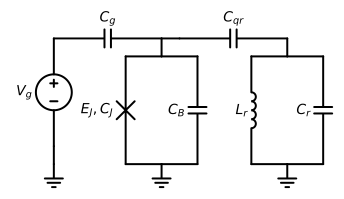

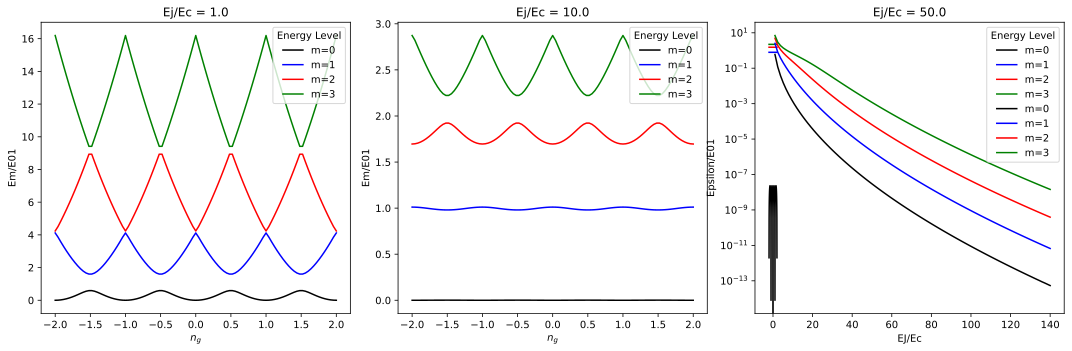

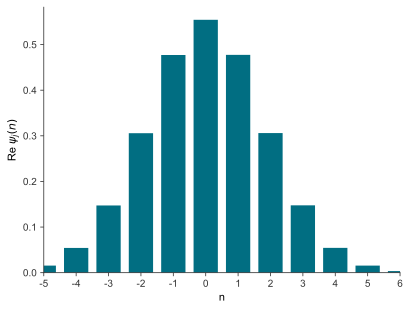

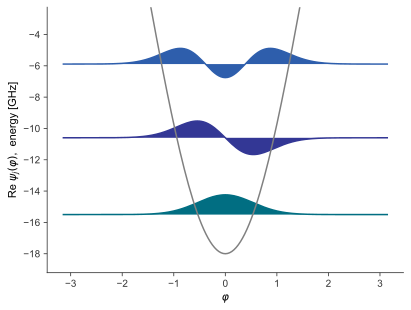

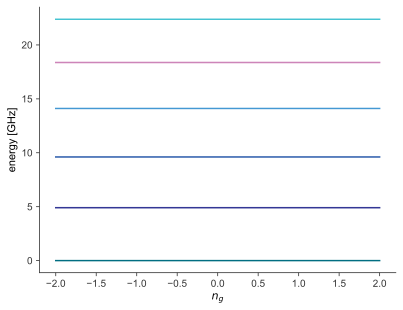

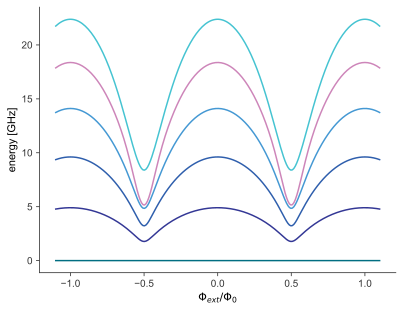

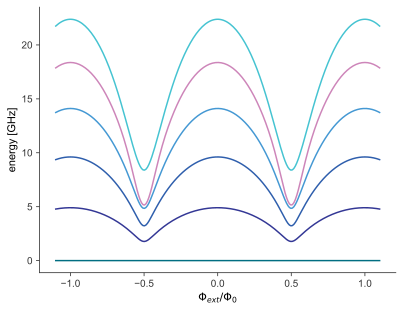

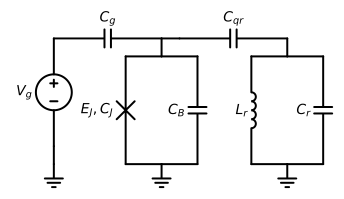

 /opt/homebrew/anaconda3/envs/sqdmetal_env/lib/python3.11/site-packages/schemdraw/backends/mpl.py: 79


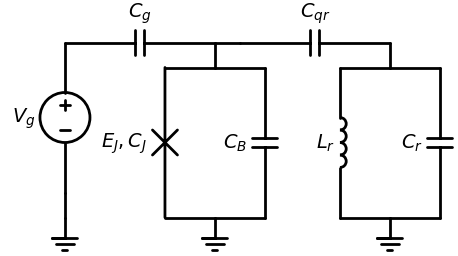

In [18]:
# Create a new drawing
d = schemdraw.Drawing()

# --- Define Nodes ---
bottom_node = (0,0) # Common ground node

# --- Draw the Transmon (Qubit) Circuit ---
# Drawing the charge line
d += elm.Ground().at(bottom_node)
d += elm.Line().up().length(0.5)
d += elm.SourceV().up().label('$V_g$')
d += elm.Capacitor().right().label('$C_g$')

# Drawing the qubit circuit
charge_node = d.here
d += elm.Line().down().length(0.5)
junction_node = d.here
d += elm.Line().left().length(1)
d += elm.Josephson().down().label('$E_J, C_J$')
d += elm.Line().right().length(1)
d += elm.Line().right().length(1).at(junction_node)
d += elm.Capacitor().down().label('$C_B$')
d += elm.Line().left().length(1)
d += elm.Ground()
d += elm.Line().right().length(0.5).at(charge_node)
d += elm.Capacitor().right().label('$C_{qr}$')

# Drawing the resonator circuit
d += elm.Line().down().length(0.5)
resonator_node = d.here
d += elm.Line().left().length(1)
d += elm.Inductor().down().label('$L_r$')
d += elm.Line().right().length(1)
d += elm.Line().right().length(1).at(resonator_node)
d += elm.Capacitor().down().label('$C_r$')
d += elm.Line().left().length(1)
d += elm.Ground()
d.draw()

A basic structure for a single qubit system can be drawn as above. We have the transmon at the center of the circuit, defined by the parallel branch of Josepshon junction and a shunting capacitor. We have added a capacitively-coupled control line to the left, which creates charge fluctuations on our qubit. In order to readout the quantum state of the qubit, we have coupled our qubit to a resonator, which is modeled as an LC resonator capacitively coupled from the right. We will use the dispersive readout concepts we learned throughout the workshop to design our readout circuit.

Our first task is determining the properties of our transmon. We will start with designing the Hamiltonian of the transmon.
The transmon Hamiltonian is given by: 

$$
\hat{H}=4E_{C}\left(\hat{n}-n_{g}\right)-E_{J}\cos\left(\hat{\phi}\right)\,,
$$

where $E_{C}$ is the charging energy, $E_{J}$ is the Josephson energy, $\hat n$ is the number of Cooper pairs transferred between charge islands, $\hat{\phi}$ is the phase difference between charge islands, and $n_{g}$ is effective offset charge of the device. Expressions for the charging energy, Josephson energy and offset charge can be written as:

$$
E_{C}=\frac{e^{2}}{2C_{\Sigma}}\,,\qquad n_{g}=-\frac{C_{d}\dot{\Phi}_{s}\left(t\right)}{2e}\:,\qquad E_{J}=\frac{\phi_{0}^{2}}{L_{J}}\,,
$$

where $C_{\Sigma} = C_{J}+C_{B}+C_{g}$ (the sum of the Josephson capacitance, shunting capacitance and gate capacitance), $L_{J}$ is the inductance of the Josephson junction, and $\phi$ is the magnetic flux. 

The  are
$$
\hat{\phi}\equiv\frac{\hat{\Phi}}{\phi_{0}},\qquad\hat{n}\equiv\frac{\hat{Q}}{2e}\,,
$$

Observe that $\hat \phi$ and $\hat n$ are both dimensionless, and they obey the commutation relationship:

$$
[\hat{\phi}, \hat{n}] = i
$$


Using the operator relations above, we can write the transmon Hamiltonian in the charge ($\hat n$) basis as given below, where $\hat{n} = \sum_{n=-\inf}^{\inf} |n\rangle\langle n|$: 

$$H=4E_\text{C}(\hat{n}-n_g)^2-\frac{1}{2}E_\text{J}\sum_n(|n\rangle\langle n+1|+\text{h.c.}),$$


Writing the transmon Hamiltonian this way will help us to easily diagonalize the Hamiltonian and extract our qubit resonances.

### Charge Dispersion

Let's model the hamiltonian to see how the energy structure looks like. For this purpose, we can either use the Hcpb class within Qiskit Metal, or we can use the open source scqubits package. 


 Let's start by defining the range of offset charge from -2.0 to +2.0 and also by defining a normalization for the eigenvalues, which will be the transition energy between the first two states evaluated at the degeneracy point where ng=0.5. For this exercise, first we'll take Josephson Energy to be equal to the charging energy and then we will check how our system behaves for different Josephson energies.

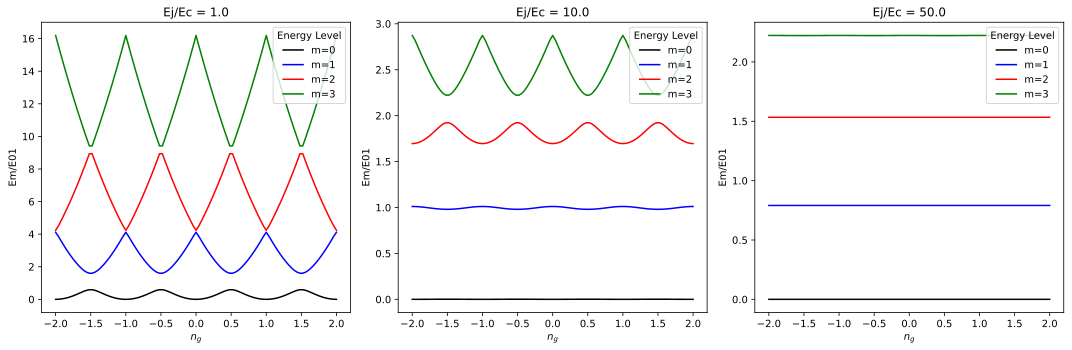

In [19]:

# Define the charging energies to iterate over
ng = np.linspace(-2.0,2.0,101) # this represents the charging energy (ng)
E_c = 220
E_j_values = [E_c * 1, E_c * 10, E_c*50]
# Create a figure with subplots
fig, axes = plt.subplots(1, len(E_j_values), figsize=(15, 5))

# Iterate over the charging energies
for ax_idx, E_j in enumerate(E_j_values):
    epsilon0, epsilon1, epsilon2, epsilon3 = [], [], [], []
    # Calculate charge dispersion for each Ej/Ec ratio
    for i in ng:
        H = Hcpb(nlevels=10, Ej=E_j, Ec=E_c, ng=i)
        H_norm = Hcpb(nlevels=2, Ej=E_j, Ec=E_c, ng=0.5)
        norm = H_norm.fij(0,1) # normalization constant
        epsilon0.append(H.evalue_k(0)/norm)
        epsilon1.append(H.evalue_k(1)/norm)
        epsilon2.append(H.evalue_k(2)/norm)
        epsilon3.append(H.evalue_k(3)/norm)
    floor = min(epsilon0)
    # Plot the charge dispersion on the current subplot
    ax = axes[ax_idx]
    ax.plot(ng, epsilon0-floor, 'k', label="m=0")
    ax.plot(ng, epsilon1-floor, 'b', label="m=1")
    ax.plot(ng, epsilon2-floor, 'r', label="m=2")
    ax.plot(ng, epsilon3-floor, 'g', label="m=3")
    ax.set_xlabel("$n_g$")
    ax.set_ylabel("Em/E01")
    ax.set_title(f"Ej/Ec = {E_j/E_c}")
    ax.legend(title="Energy Level", loc='upper right')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


In the figures above, we see that the change in the frequency with the offset charges reduce with increasing $E_J/E_C$ ratio. This is very important for the coherence of our qubits, since the charge noise present in your environment would couple to your qubit anytime and cause frequency fluctuations. These frequency fluctuations cause incoherence for your qubits.


As we see here, for a transmon with equal inductive and capacitive energy, we observe huge swings in frequency with the gate charge, which is called charge dispersion.The peak-to-peak value of the charge dispersion for the mth energy level is given by the expression: $\epsilon_{m} = E_{m}(n_{g}=0.5) - E_{m}(n_{g}=0.0)$. We can plot $\epsilon_{m}/E_{01}$ as a function of $E_{J}/E_{C}$ for the first few energy levels.

We can start by defining a value of charging energy and creating empty lists for $\epsilon_{0}$ through $\epsilon_{4}$: 

In [20]:
E_c=220.0 # charging energy 
epsilon0, epsilon1, epsilon2, epsilon3 = [], [], [], []    # charge dispersion for m=0 through m=4
x = np.linspace(1,140,101)           # this this ratio of Ej/Ec which will go on the x-axis. 

Next, we simply evaluate the expression given above for $\epsilon_{m}$ based on $E_{m}$ and $E_{0}$. We use two separate Hamiltonians to do this; one evaluated at $n_{g}=0.5$ and one evaluated at $n_{g}=0.0$. We also normalize by the transition energy between the lowest two states evaluated at the degeneracy point ($E_{01}$.) Finally, we populate the lists each $\epsilon_{m}$. 

In [21]:
for i in x:
    E_j = i*E_c 
    H_zero = Hcpb(nlevels=15, Ej=i*E_c, Ec=E_c, ng=0.0)
    H_half = Hcpb(nlevels=15, Ej=i*E_c, Ec=E_c, ng=0.5)
    
    H_norm = Hcpb(nlevels=15, Ej=i*E_c, Ec=E_c, ng=0.5)
    norm = H_norm.fij(0,1)                         # normalization constant 
    
    epsilon0.append(abs(H_half.evalue_k(0) - H_zero.evalue_k(0))/norm)
    epsilon1.append(abs(H_half.evalue_k(1) - H_zero.evalue_k(1))/norm)
    epsilon2.append(abs(H_half.evalue_k(2) - H_zero.evalue_k(2))/norm)
    epsilon3.append(abs(H_half.evalue_k(3) - H_zero.evalue_k(3))/norm)

We can plot these values to see the exponential decrease in the charge dispersion with increasing $E_{J}/E_{C}$. The important feature of a transmon qubit is insensitivity to the charge noise due to large $E_J/E_C$ ratio. This is ensured by adding a parallel capacitance $C_B$ to the josephson junction.

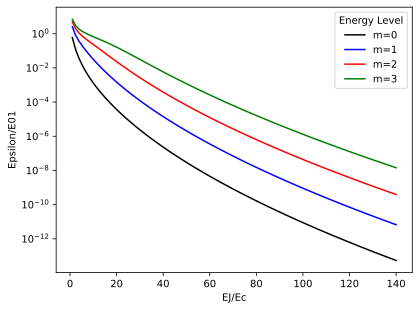

In [22]:
plt.plot(x, epsilon0, 'k', label="m=0")
plt.plot(x, epsilon1, 'b', label="m=1")
plt.plot(x, epsilon2, 'r', label="m=2")
plt.plot(x, epsilon3, 'g', label="m=3") 
plt.yscale("log")
plt.xlabel("EJ/Ec")
plt.ylabel("Epsilon/E01")
plt.legend(title="Energy Level", loc='upper right')

Now, let's use another useful package called scqubits to calculate our transmon qubit frequencies. scqubits will help us to diagonalize our hamiltonian and extract the resonance of the qubit

In [23]:
import scqubits as scq

qubit = scq.Transmon(
    EJ=18, # GHz, Josephson energy
    EC=0.18, # GHz, charging energy
    ng=0.001, # offset charge
    ncut=40, # number of levels to consider
    truncated_dim=4     # after diagonalization, we will keep 3 levels
)
evals = qubit.eigenvals(evals_count=12)
frequency_q = (evals[1] - evals[0])
print(f"Frequency of 01 transition = {(evals[1] - evals[0])* 1000:.0f} MHz")
print(f"Anharmonicity = {((evals[2] - evals[1]) - (evals[1] - evals[0]))* 1000:.0f} MHz")

Frequency of 01 transition = 4904 MHz
Anharmonicity = -197 MHz


We set our qubit to have an $E_J/E_C$ ratio of 100. Let's have a look at how our qubit wavefunction looks like in terms of charge and flux basis.

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='$\\varphi$', ylabel='Re $\\psi_j(\\varphi)$,  energy [GHz]'>)

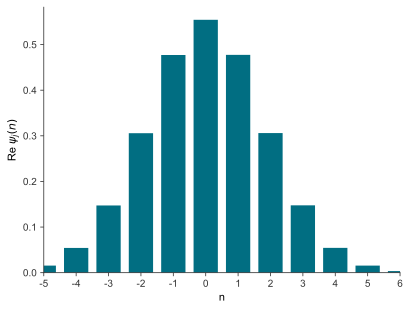

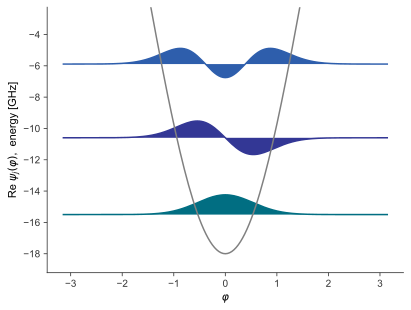

In [24]:
#Plot the wavefunction in charge and flux basis
qubit.plot_n_wavefunction()
qubit.plot_phi_wavefunction(which=[0,1,2], mode='real')

As we see, our qubit wavefunction is highly delocalized in the charge basis, while it is localized in flux basis within the cosine potential due to Josephson junction. This delocalization helps us to be independent from the offset gate charge fluctuations.

Spectral data:   0%|          | 0/220 [00:00<?, ?it/s]

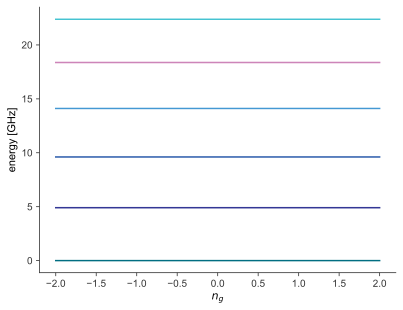

In [25]:
#Again, we can plot the eigenvalues as a function of gate charges to get an idea of charge dispersion.
ng_list = np.linspace(-2, 2, 220)
qubit.plot_evals_vs_paramvals('ng', ng_list, evals_count=6, subtract_ground=True);

As we see from the wavefunction in the flux basis, we can identify our transmon as a weakly anharmonic oscillator in flux basis and diagonalize the Hamiltonian to obtain our energy eigenstates in terms of ladder operations $\hat{b}$ and $\hat{b}^{\dag}$, i.e. number of excitations. 

In this case, our Hamiltonian becomes:

$$
\hat{H}= \hbar\omega_q \hat{b}^{\dag}\hat{b}-\frac{E_C}{2} \hat{b}^{\dag}\hat{b}^{\dag}\hat{b}\hat{b}
$$
where, $\hbar\omega_q = \sqrt{8E_CE_J}-E_C$, which corresponds to the transition frequency between ground and first excited state. This transition is where quantum states are logically assigned.

The second component of the Hamiltonian depends on number of excitations present, which changes the transition frequency between higher excited states. This term is what makes our transmon oscillator anharmonic, where transition frequencies between each level are different from each other. The anharmonicity(or qubit nonlinearity) $\alpha$ is approximately equal to $E_C$, and helps us to distinguish between different qubit transitions, which is important for high-fidelity control of the qubits and prevent leakage to higher order transitions.

While designing a qubit, the important considerations are:
- Determine $E_J$ and $E_C$ according to the desired qubit frequency
- Having a large enough $E_J/E_C$ ratio to suppress the effects of charge noise
- Finally, having an appropriate $E_C$ (~100-400 MHz) to achieve better control and prevent leakage.

In summary, the $E_J$ and $E_C$ values are not independent from each other and should be carefully determined according to the qubit frequency regime desired for operation. Let's use the transmon parameters we used to simulate with scqubits to design our device.

In [26]:
import qiskit_metal.analyses.quantization.lumped_capacitive as lumped_cap
E_c = 0.18 # charging energy # GHz
E_j = 18 # Josephson energy
C_shunt  = lumped_cap.Cs_from_Ec(hbar*2*np.pi*E_c*1e9)  # input in Joules, thus multiplied by Planck's constant
I_junction = lumped_cap.Ic_from_Ej(hbar*2*np.pi*E_j*1e9) #input in Joules, thus multiplied by Planck's constant
L_junction = flux_0 / (2 * np.pi * I_junction) # in H
print(f"Shunt capacitance = {C_shunt*1e15:.2f} fF")
print(f"Junction critical current = {I_junction*1e9:.2f} nA")
print(f"Junction inductance = {L_junction*1e9:.2f} nH")
# Calculate the ratio of EJ/EC
print(f"EJ/EC = {E_j/E_c:.2f}")

Shunt capacitance = 107.61 fF
Junction critical current = 36.26 nA
Junction inductance = 9.09 nH
EJ/EC = 100.00


## Tunable Transmon

State of the art transmon devices are designed to have a tunable frequency, in order to be able to tune qubit properties to have best coherence, or to bring two qubits in resonance for achieving high-fidelity two qubit gate operations. For this purpose, the single Josephson Junction in transmon is replaced by a SQUID loop of two parallel Josephson Junctions. Such a qubit can be tuned by applying an external magnetic field within the loop. 

The flux sensitivity of tunable transmons can be reduced at the expense of tunable range, which improves coherence of the qubit under the presence of flux noise.

The Hamiltonian of a tunable transmon becomes :

$$
H = 4E_C\hat{n}^2 - E_{J\Sigma}\sqrt{cos^2(\phi_{ext})+ d^2 sin^2(\phi_{ext})} cos(\phi)
$$
where $E_{J\Sigma} = E_{J1} + E_{J2}$ and $ d = E_{J1} - E_{J2}/E_{J\Sigma}$. Thus we can treat this Hamiltonian as a single-junction transmon with effective Josepshon energy of $E_{J\Sigma}\sqrt{cos^2(\phi_{ext})+ d^2 sin^2(\phi_{ext})}$. The Josephson energy is controlled by the external flux $\phi_{ext}$.

Spectral data:   0%|          | 0/220 [00:00<?, ?it/s]

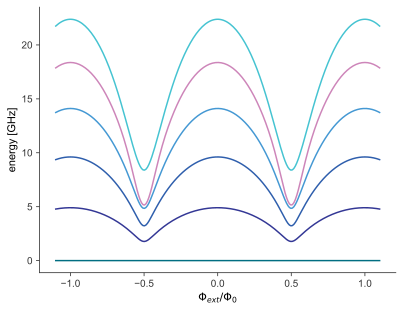

In [28]:
tune_tmon = scq.TunableTransmon(
    EJmax=18,
    EC=0.18,
    d=0.15,
    flux=0.0,
    ng=0.0,
    ncut=40
)

flux_list = np.linspace(-1.1, 1.1, 220)
tune_tmon.plot_evals_vs_paramvals('flux', flux_list, subtract_ground=True);

# Capacitance simulation of the qubit

Let's start designing our qubit and simulating our qubit capacitances to obtain desired parameters using Palace.

In [36]:
design = designs.DesignPlanar({}, overwrite_enabled=True)
design.delete_all_components()
gui = MetalGUI(design)


# Set up chip dimensions 
design.chips.main.size.size_x = '2.4mm'
design.chips.main.size.size_y = '2.4mm'
design.chips.main.size.size_z = '-280um'
design.chips.main.size.center_x = '0mm'
design.chips.main.size.center_y = '-1mm'

# Resonator and feedline gap width (W) and center conductor width (S) 
design.variables['cpw_width'] = '10 um' #S
design.variables['cpw_gap'] = '6 um' #W 
# Lets create the qubit with a junction and a claw

### Qubit
# Qubit
xmon = Xmon(design, 'xmon', options=Dict(pos_x = '0', pos_y='-1',
                                    vBar_width='50um', hBar_width='50um', vBar_gap=f'{50}um', hBar_gap=f'{50}um',
                                    cross_width=f'{320}um', cross_height=f'{320}um',
                                    gap_up='40um', gap_left='40um', gap_right='40um', gap_down='40um'))

# Junction
JunctionDolanPinStretch(design, 'junction', options=Dict(pin_inputs=Dict(start_pin=Dict(component=f'xmon',pin='right')),
                                                         dist_extend='40um',
                                                         layer=2,
                                                         finger_width='0.4um', t_pad_size='0.385um',
                                                         squid_width='5.4um', prong_width='0.9um'))


# Claw
CapacitorProngPin(design, 'claw', options=Dict(pin_inputs=Dict(start_pin=Dict(component=f'xmon',pin='up')),
                                                prong_width='10um', prong_length='20um', pin_gap_side='10um',
                                                gap_side='20um', pad_thickness='20um',
                                                gap_front='20um', gap_back='20um', trace_width='10um'))

# Check the design
# rebuild the GUI
design.rebuild()
gui.rebuild()
gui.autoscale()
# gui.screenshot('xmon.png')

In [37]:
from SQDMetal.PALACE.Capacitance_Simulation import PALACE_Capacitance_Simulation
# Define the options for the simulation
user_defined_options = {
                "mesh_refinement": 0,                             #refines mesh in PALACE - essetially divides every mesh element in half
                "dielectric_material": "silicon",                  #choose dielectric material - 'silicon' or 'sapphire'
                "solver_order": 1,                                 #increasing solver order increases accuracy of simulation, but significantly increases sim time
                "solver_tol": 1.0e-8,                              #error residual tolerance for iterative solver
                "solver_maxits": 500,                              #number of solver iterations
                "mesh_max": 120e-6,                                #maxiumum element size for the mesh in mm
                "mesh_sampling": 150,                              #number of points to mesh along a geometry
                "fillet_resolution":12,                            #number of vertices per quarter turn on a filleted path
                "num_cpus": 10,                                      #number of CPU cores to use for simulation
                "palace_dir":path_to_palace
                }

In [38]:
# initialize the meshing environment
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
os.environ["PMIX_MCA_gds"]="hash"

import gmsh
gmsh.initialize()


os.makedirs('sims', exist_ok=True)

In [39]:
#Create the Palace Eigenmode simulation
cap_sim = PALACE_Capacitance_Simulation(name = 'transmon_cross_cap_sim',                                 #name of simulation
                                        metal_design = design,                                      #feed in qiskit metal design
                                        sim_parent_directory = "sims/",            #choose directory where mesh file, config file and HPC batch file will be saved
                                        mode = 'simPC',                                             #choose simulation mode 'HPC' or 'simPC'
                                        meshing = 'GMSH',                                           #choose meshing 'GMSH' or 'COMSOL'
                                        user_options = user_defined_options,                        #provide options chosen above
                                        view_design_gmsh_gui = False,                               #view design in GMSH gui
                                        create_files = True,
                                        )                                        #create mesh, config and HPC batch files

cap_sim.add_metallic(1, threshold=1e-10, fuse_threshold=1e-10)
cap_sim.add_ground_plane(threshold=1e-10)

In [40]:
# Retrieve the bounds of the qubit for finer meshing
bounds = design.components["xmon"].qgeometry_bounds()
bounds

array([-0.2, -1.2,  0.2, -0.8])

In [41]:
#Fine-mesh the transmon cross qubit region
cap_sim.fine_mesh_in_rectangle(bounds[0]*1e-3, bounds[1]*1e-3, bounds[2]*1e-3, bounds[3]*1e-3, mesh_sampling=100, mesh_min=1e-6, mesh_max=50e-3)

In [42]:
# prepare the simulation files
cap_sim.prepare_simulation()

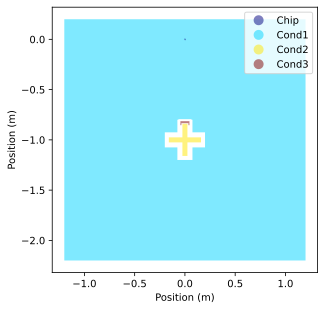

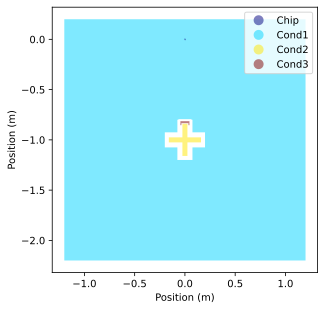

In [43]:
# The order of the components in this figure will help us to identify the indices of the capacitance matrix
cap_sim.display_conductor_indices()

In [44]:
cap_matrix = cap_sim.run()

>> /opt/homebrew/bin/mpirun -n 10 /Users/mcansarihan/qubit_design/palace/build/bin/palace-arm64.bin transmon_cross_cap_sim.json

_____________     _______
_____   __   \____ __   /____ ____________
____   /_/  /  __ ` /  /  __ ` /  ___/  _ \
___   _____/  /_/  /  /  /_/  /  /__/  ___/
  /__/     \___,__/__/\___,__/\_____\_____/


--> Warning!
Output folder is not empty; program will overwrite content! (outputFiles)
Git changeset ID: v0.13.0-454-gcd4d7b78
Running with 10 MPI processes
Device configuration: cpu
Memory configuration: host-std
libCEED backend: /cpu/self/xsmm/blocked

Added 17 elements in 1 iterations of local bisection for under-resolved interior boundaries
Added 2387 duplicate vertices for interior boundaries in the mesh
Added 5178 duplicate boundary elements for interior boundaries in the mesh
Added 520 boundary elements for material interfaces to the mesh
Finished partitioning mesh into 10 subdomains

Characteristic length and time scales:
 L₀ = 2.880e-03 m, t₀ = 9.607e

In [45]:
cdf = pd.DataFrame(cap_matrix*1e15)

# get rid of the first column
cdf = cdf.iloc[:, 1:]

# assigning the columns and indices based on our geometry
cdf.columns = ["ground", "xmon", "claw"]
cdf.index = ["ground", "xmon", "claw"]
cdf = cdf.reindex(index=["ground", "claw", "xmon"], columns=["ground", "claw", "xmon"])
cdf

,ground,claw,xmon
ground,2456.000983,-16.709319,-68.180366
claw,-16.709319,35.008264,-16.165544
xmon,-68.180366,-16.165544,106.336536


We obtained the capacitance matrix for the transmon cross qubit. The values are in femtofarads (fF).
The diagonal elements of the capacitance matrix represent the self-capacitance of each component, while the off-diagonal elements represent the mutual capacitance between components.
The self-capacitance of the transmon cross is 106.33 fF, while the self-capacitance of the claw is 35 fF. The mutual capacitance between the transmon cross and the claw is 16 fF.

# The Jaynes-Cummings model

The Jaynes-Cummings mode describes a system composed of a qubit (two-level system) coupled to a harmonic oscillator. The coupling is such that a qubit excitation can be "converted" into a photon and vice versa,

$\displaystyle H=-\frac{\omega_q}{2}\sigma_z + \omega_r a^\dagger a + g (a\sigma_+ + a^\dagger \sigma_-)$

This model can be solved exactly, resulting in the following eigenenergies:

$\displaystyle E_0 = -\frac{1}{2}\omega_q$,

$\displaystyle E_{n\pm} =  \bigg(n-\frac{1}{2}\bigg) \omega_r \pm \sqrt{\frac{\Delta^2}{4}+n g^2}$,

where $\Delta=\omega_r-\omega_q$ and $n=1,2,\ldots$.

Let's simulate the transmon-resonator coupled system in scqubits first! We defined our resonator at 6 GHz and set our interaction rate, g to 50 MHz.

In [60]:
frequency_r = 6
g = 0.05
qubit_generic = scq.GenericQubit(E = frequency_q )
osc = scq.Oscillator(
    E_osc=frequency_r,
    truncated_dim=10  # up to 9 photons
)

In [61]:
# Form a list of all components making up the Hilbert space.
hilbertspace = HilbertSpace([qubit_generic, osc])

hilbertspace.add_interaction(
    g_strength = g,
    op1 = qubit_generic.sm_operator,
    op2 = osc.creation_operator,
    add_hc = True
)

In [62]:
evals = hilbertspace.eigenvals(evals_count=6)
print(evals)

[-2.4520622   2.44978565  3.55021435  8.44751848  9.55248152 14.44526057]


When the detuning between the qubit and the resonator is less than the coupling rate, the energy levels of the qubit and the resonator hybridize and and a Rabi splitting of $2\sqrt{n}g$ forms up between two modes. In this case there will be coherent swapping interactions between two systems. This would change the qubit state when a measurement needs to be done on the qubit. 

In order to achieve a readout without destroying the stored quantum information, we detune our resonator so that $g << |f_q - f_r|$, which is also called as dispersive limit. In the dispersive limit, there is no exchange interaction between qubits, but a state-dependent frequency shift, $\chi$, between two systems. 

In the dispersive limit, the Hamiltonian of the system becomes:

$$
H_{disp} = (\omega_r + \chi\sigma_z)(a^{\dag}a + 1/2) + (\omega_q + \chi)\sigma_z
$$
where $\chi = g^2/\Delta $, assuming the qubit energy levels are truncated to 0-1 states. This approximation is only valid at low photon numbers $n = a^{\dag}a < \Delta^2/(4g^2)$.


While designing readout system, we need to be mindful about the interplay between readout speed, fidelity and qubit coherence. The qubit readout is done by analyzing the state-dependent frequency and phase shift of the resonator over time. Thus, larger resonator dissipation rate, $\kappa$, and dispersive shift $\chi$, would lead to faster and better state readout. 

On the other hand, $\chi$ scales with coupling strength, which requires a stronger coupling between qubit and resonator in order to increase the dispersive shift. A high dispersive shift exposes qubit to the outside world, thus cause a loss in coherence.

When the readout dynamics are analyzed carefully, the maximal state distinguishability is reached when $2\chi = \kappa$ as a simple rule of thumb. As a designer, you should consider your coherence limits and how they are affected by the qubit-resonator coupling.

Here, let's work on a resonator design that satisfies this criteria.

# Drawing transmon + resonator system

Let's add a readout resonator to our transmon and simulate below. We will be using a lambda\2 coplanar waveguide based transmission line resonator to do readout.

The resonance frequency of a resonator is given by: 

$$
f_{res} = \frac {c}{\sqrt \epsilon_{eff}} \frac{1}{2l}
$$

where l is the length of the resonator and $v_p = \frac {c}{\sqrt \epsilon_{eff}}$ is phase velocity of the waveguide. 

Phase velocity is dependent on the effective permittivity of the coplanar waveguide. The permittivity of silicon substrate is 11.45, and the mode of coplanar waveguide is distributed between silicon and air. Thus as a first initial guess, we can take $\epsilon_{eff} = (11.45 + 1)/2 \approx 6.22$. Phase velocity $v_p$ can also be extracted using inductance and capacitance of resonator per unit length, $v_p = 1/ \sqrt{L_r C_r}$. A careful EM simulation is required to extract exact parameters, since the phase velocity will also depend on the geometry of the resonator and presence of other layers.

Another important parameter for the resonator is its characteristic impedance, $Z_0 = \sqrt{\frac{L_r}{C_r}}$. For good impedance matching with respect to rest of the microwave circuit and control lines going out of the device, we will adjust our coplanar waveguide geometry to have $Z_0 = 50 \Omega$.


The resonator is coupled to a bus waveguide from the open-end. At the open-end the voltage and capacitive energy of the resonator is at maximum, thus, the resonator-bus coupling is highly capacitive. We can control the resonator decay rate $\kappa$, by controlling the length and gap of the coupling region.


In [ ]:
# Let's calculate the approximate length of the resonator for 6 GHz resonant frequency
length_approx = 3e8 / np.sqrt(6.2) /6e9/2 * 1000
print(f"Approximate length of the resonator = {length_approx:.2f} mm")

Approximate length of the resonator = 10.04 mm


The approximate length we obtained above is a good starting point, however the actual resonance frequency will also depend on the terminations and couplings to the resonator. Capacitances present in the circuit will cause phase delays, and alter the resonance frequency.

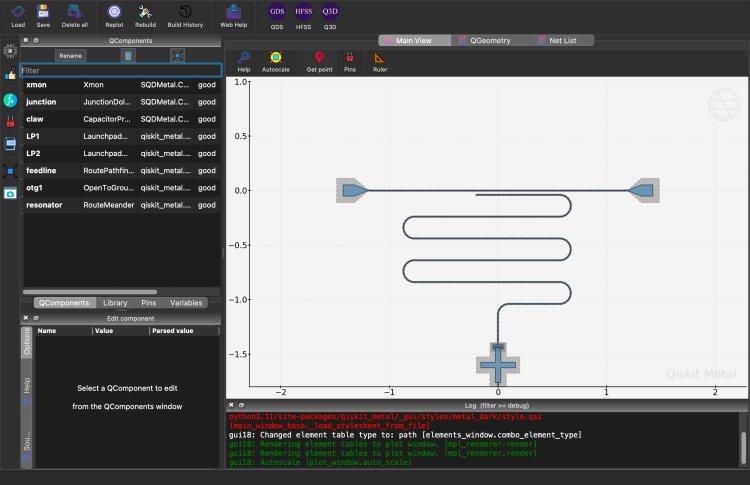

In [113]:
design = designs.DesignPlanar({}, overwrite_enabled=True)
design.delete_all_components()
gui = MetalGUI(design)


# Set up chip dimensions 
design.chips.main.size.size_x = '3.5mm'
design.chips.main.size.size_y = '3mm'
design.chips.main.size.size_z = '-280um'
design.chips.main.size.center_x = '0mm'
design.chips.main.size.center_y = '-1mm'

# Resonator and feedline gap width (W) and center conductor width (S) 
design.variables['cpw_width'] = '8 um' #S
design.variables['cpw_gap'] = '4 um' #W 
# Lets create the qubit with a junction and a claw

## Qubit
xmon = Xmon(design, 'xmon', options=Dict(pos_x = '0mm', pos_y='-1.6',
                                    vBar_width='50um', hBar_width='50um', vBar_gap=f'{50}um', hBar_gap=f'{50}um',
                                    cross_width=f'{320}um', cross_height=f'{320}um',
                                    gap_up='40um', gap_left='40um', gap_right='40um', gap_down='40um'))

# Junction
JunctionDolanPinStretch(design, 'junction', options=Dict(pin_inputs=Dict(start_pin=Dict(component=f'xmon',pin='down')),
                                                         dist_extend='40um',
                                                         layer=2,
                                                         finger_width='0.4um', t_pad_size='0.385um',
                                                         squid_width='5.4um', prong_width='0.9um'))


# # Claw
CapacitorProngPin(design, 'claw', options=Dict(pin_inputs=Dict(start_pin=Dict(component=f'xmon',pin='up')),
                                                prong_width='10um', prong_length='20um', pin_gap_side='10um',
                                                gap_side='20um', pad_thickness='20um',
                                                gap_front='20um', gap_back='20um', trace_width='10um'))

# Lauchpad 1
x1 = '-1.2mm'
y1 = '0mm'
launch_options1 = dict(chip='main', pos_x=x1, pos_y=y1, orientation='360', lead_length='30um', pad_height='103um', 
                      pad_width='103um', pad_gap='60um')
LP1 = LaunchpadWirebond(design, 'LP1', options = launch_options1)

# Launchpad 2
x2 = '1.2mm'
y1 = '0mm'
launch_options2 = dict(chip='main', pos_x=x2, pos_y=y1, orientation='180', lead_length='30um', pad_height='103um', 
                      pad_width='103um', pad_gap='60um')
LP2 = LaunchpadWirebond(design, 'LP2', options = launch_options2)

# Using path finder to connect the two launchpads
feedline = RoutePathfinder(design, 'feedline', options = dict(chip='main', trace_width ='8um',
                                            trace_gap ='4um',
                                            fillet='200um',                                                            
                                            hfss_wire_bonds = True,
                                            lead=dict(end_straight='0.1mm'),
                                            pin_inputs=Dict(
                                                start_pin=Dict(
                                                    component='LP1',
                                                    pin='tie'),
                                                end_pin=Dict(
                                                    component='LP2',
                                                    pin='tie')
                                            )))
#open to ground for resonator
otg1 = OpenToGround(design, 'otg1', options=dict(chip='main', pos_x='-0.2mm',  pos_y='-40um', orientation = 180, width = '8um', gap='4um',))

# Use RouteMeander to fix the total length of the resonator
res1 = RouteMeander(design, 'resonator',  Dict(
        trace_width ='8um',
        trace_gap ='4um',
        total_length='8.6mm',
        hfss_wire_bonds = False,
        fillet='100um',
        lead = dict(start_straight='100um'),
        meander = dict(spacing='0.2mm'),
        pin_inputs=Dict(
        start_pin=Dict(component= 'otg1', pin= 'open'),
        end_pin=Dict(component= 'claw', pin= 'a')), ))

# rebuild the GUI
design.rebuild()
gui.rebuild()
gui.autoscale()
gui.screenshot('sims/qubit-cavity.png')


## Eigenmodal Simulation



Define the hyper-parameters for the eigenmode simulation

In [114]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
os.environ["PMIX_MCA_gds"]="hash"

import gmsh
gmsh.initialize()

In [115]:
# Define the hyper-parameters for the eigenmode simulation
from SQDMetal.PALACE.Eigenmode_Simulation import PALACE_Eigenmode_Simulation

#Eigenmode Simulation Options
user_defined_options = {
                 "mesh_refinement":  0,                             #refines mesh in PALACE - essetially divides every mesh element in half
                 "dielectric_material": "silicon",                  #choose dielectric material - 'silicon' or 'sapphire'
                 "starting_freq": 3e9,                              #starting frequency in Hz 
                 "number_of_freqs":6,                              #number of eigenmodes to find
                 "solns_to_save": 6,                                #number of electromagnetic field visualizations to save
                 "solver_order": 1,                                 #increasing solver order increases accuracy of simulation, but significantly increases sim time
                 "solver_tol": 5.0e-4,                              #error residual tolerance foriterative solver
                 "solver_maxits": 10,                              #number of solver iterations
                 "mesh_max": 120e-3,                                #maxiumum element size for the mesh in mm
                 "mesh_min": 10e-3,                                 #minimum element size for the mesh in mm
                 "mesh_sampling": 130,                              #number of points to mesh along a geometry
                 "fillet_resolution":12,   
                 "num_cpus": 4,                                      #number of CPU cores to use for simulation
                 "palace_dir":path_to_palace
                }

#Creat the Palace Eigenmode simulation
eigen_sim = PALACE_Eigenmode_Simulation(name ='GMSH_eigen_test',                              #name of simulation
                                        metal_design = design,                                      #feed in qiskit metal design
                                        sim_parent_directory = "sims/",            #choose directory where mesh file, config file and HPC batch file will be saved
                                        mode = 'simPC',                                               #choose simulation mode 'HPC' or 'simPC'                                          
                                        meshing = 'GMSH',                                         #choose meshing 'GMSH' or 'COMSOL'
                                        user_options = user_defined_options,                        #provide options chosen above
                                        view_design_gmsh_gui = False,                               #view design in GMSH gui 
                                        create_files = True)                                        #create mesh, config and HPC batch files

# Assigning the materials to the interfaces, add ports to the design, and add some mesh.


eigen_sim.add_metallic(1, threshold=1e-10, fuse_threshold=1e-10)
eigen_sim.add_ground_plane(threshold=1e-10)

#Fine-mesh the transmon cross qubit region
bounds = design.components["xmon"].qgeometry_bounds()
eigen_sim.fine_mesh_in_rectangle(bounds[0]*1e-3, bounds[1]*1e-3, bounds[2]*1e-3, bounds[3]*1e-3, mesh_sampling=100, mesh_min=15e-6, mesh_max=120e-6)

#Add in the RF ports
eigen_sim.create_port_CPW_on_Launcher('LP1', 20e-6,)
eigen_sim.create_port_CPW_on_Launcher('LP2', 20e-6,)
eigen_sim.create_port_JosephsonJunction('junction', L_J=L_junction, C_J=2e-15)

# #Fine-mesh routed paths

eigen_sim.fine_mesh_around_comp_boundaries(['feedline', 'resonator'], min_size=15e-6, max_size=250e-6)
eigen_sim.fine_mesh_around_comp_boundaries(['xmon','junction'], min_size=14e-6, max_size=75e-6)

eigen_sim.setup_EPR_interfaces(metal_air=MaterialInterface('Aluminium-Vacuum'), substrate_air=MaterialInterface('Silicon-Vacuum'), substrate_metal=MaterialInterface('Silicon-Aluminium'))
eigen_sim.prepare_simulation()

In [116]:
from SQDMetal.PALACE.Utilities.GMSH_Navigator import GMSH_Navigator

# Let's look how the mesh looks in GMSH
# Open the GMSH GUI

gmsh_nav = GMSH_Navigator(eigen_sim.path_mesh)
gmsh_nav.open_GUI()

In [117]:
import json

#This is required for Palace to run eigenmode simulation while 50 ohm ports are used
with open(eigen_sim._sim_config, 'r') as file:
    sim_config_dict = json.load(file)
print(sim_config_dict)

del sim_config_dict["Boundaries"]["LumpedPort"][0]["Excitation"]

with open(eigen_sim._sim_config, 'w') as file:
    json.dump(sim_config_dict, file, indent=4)

{'Problem': {'Type': 'Eigenmode', 'Verbose': 2, 'Output': 'outputFiles'}, 'Model': {'Mesh': 'GMSH_eigen_test.msh', 'L0': 0.001, 'Refinement': {'UniformLevels': 0}}, 'Domains': {'Materials': [{'Attributes': [12], 'Permeability': 1.0, 'Permittivity': 1.0, 'LossTan': 0.0}, {'Attributes': [11], 'Permeability': 1, 'Permittivity': 11.45, 'LossTan': 2.7e-06}]}, 'Boundaries': {'PEC': {'Attributes': [1, 2, 3, 4]}, 'LumpedPort': [{'Index': 1, 'Elements': [{'Attributes': [5], 'Direction': [-0.0, -1.0, 0]}, {'Attributes': [6], 'Direction': [0.0, 1.0, 0]}], 'R': 50, 'L': 0, 'C': 0, 'Excitation': True}, {'Index': 2, 'Elements': [{'Attributes': [7], 'Direction': [0.0, 1.0, 0]}, {'Attributes': [8], 'Direction': [-0.0, -1.0, 0]}], 'R': 50, 'L': 0, 'C': 0}, {'Index': 3, 'Attributes': [9], 'Direction': [0.0, -1.0, 0], 'R': 0, 'L': 9.089882230412858e-09, 'C': 2e-15}], 'Postprocessing': {'Dielectric': [{'Index': 1, 'Attributes': [10], 'Type': 'SA', 'Thickness': 2e-06, 'Permittivity': 3.85, 'LossTan': 0.006

In [118]:
# If all looks good, lets run the simulation
eigen_sim.run()

>> /opt/homebrew/bin/mpirun -n 4 /Users/mcansarihan/qubit_design/palace/build/bin/palace-arm64.bin GMSH_eigen_test.json

_____________     _______
_____   __   \____ __   /____ ____________
____   /_/  /  __ ` /  /  __ ` /  ___/  _ \
___   _____/  /_/  /  /  /_/  /  /__/  ___/
  /__/     \___,__/__/\___,__/\_____\_____/


--> Warning!
Output folder is not empty; program will overwrite content! (outputFiles)
Git changeset ID: v0.13.0-454-gcd4d7b78
Running with 4 MPI processes
Device configuration: cpu
Memory configuration: host-std
libCEED backend: /cpu/self/xsmm/blocked

Added 3890 elements in 2 iterations of local bisection for under-resolved interior boundaries
Added 8152 duplicate vertices for interior boundaries in the mesh
Added 19899 duplicate boundary elements for interior boundaries in the mesh
Added 1442 boundary elements for material interfaces to the mesh
Finished partitioning mesh into 4 subdomains

Characteristic length and time scales:
 L₀ = 4.200e-03 m, t₀ = 1.401e-02 ns

In [119]:
# Reading the eigenmode data now
def read_csv_to_dataframe(file_path):
    return pd.read_csv(file_path)

eigen_df = read_csv_to_dataframe(os.path.join(eigen_sim._output_data_dir, 'eig.csv'))
eigen_df.columns = eigen_df.columns.str.strip()
eigen_df["kappa (kHz)"] = eigen_df["Re{f} (GHz)"] / eigen_df["Q"] * 1e6
eigen_df

,m,Re{f} (GHz),Im{f} (GHz),Q,Error (Bkwd.),Error (Abs.),kappa (kHz)
0,1.0,4.294672,3.728500,0.762686,1.311703e-07,0.054535,5.630985e+06
1,2.0,4.866492,0.003324,732.099651,3.275360e-08,0.013617,6.647308e+03
2,3.0,5.985255,0.178352,16.786758,4.949583e-08,0.020578,3.565462e+05
3,4.0,6.221594,-0.015715,197.948608,7.640377e-08,0.031765,3.143035e+04
4,5.0,7.845751,5.704525,0.850236,2.915638e-07,0.121221,9.227736e+06
5,6.0,12.078226,0.440316,13.724510,2.773485e-07,0.115311,8.800479e+05
6,7.0,12.169380,1.563726,3.923140,3.667072e-07,0.152463,3.101949e+06


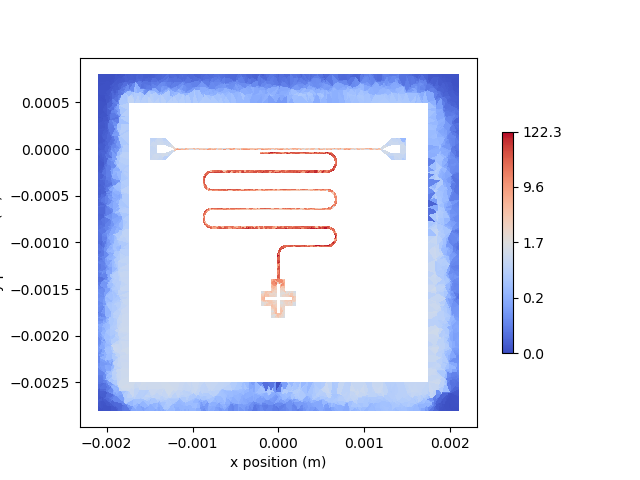

In [158]:
from IPython.display import display, Image
mode_num = 3
display(Image(filename=f"{eigen_sim._output_data_dir}/eig{mode_num}_ErealMag.png"))

In [134]:
mode_dict = eigen_sim.retrieve_mode_port_EPR_from_file(eigen_sim._output_data_dir)

#get particpation ratios and frequencies from the simulation
participation_ratios = mode_dict['mat_mode_port']
frequencies = mode_dict['eigenfrequencies']

In [135]:
participation_ratios

array([[-8.69061641e-03],
       [ 3.00642133e+01],
       [ 4.96358298e-04],
       [-2.50668524e-01],
       [-9.16442342e-03],
       [ 6.25070017e-04],
       [-4.54142384e-03]])

In [154]:
qubit_idx = 1
cavity_idx = 3

linear_qubit_freq = eigen_df['Re{f} (GHz)'][qubit_idx]*1e9
linear_res_freq = eigen_df['Re{f} (GHz)'][cavity_idx]*1e9
P_qubit = abs(participation_ratios[qubit_idx, 0])
P_cav = abs(participation_ratios[cavity_idx, 0])

In [155]:
P_qubit, P_cav

(30.06421332999, 0.2506685239554)

In [156]:
#Constants used for calculations
from scipy.constants import Planck, e, hbar
phi0 = hbar/(2*e)

#Josephson Energy (Ej) and linear inductance (Lj)
delta_super = (1.8e-4 / 2) * e
Lj = L_junction 
Ej = phi0**2 / Lj

#Normalize Participation Ratios
P_qubit_normalised = P_qubit / (P_qubit + P_cav)
P_cav_normalised = P_cav / (P_qubit + P_cav)

#Enter in Frequencies from Simulation
omega_qubit = 2 * np.pi * linear_qubit_freq
omega_res = 2 * np.pi * linear_res_freq

#phi zero-point fluctuations for qubit
phi_zpf_sq = P_qubit_normalised * hbar * 2 * omega_qubit  / (2*Ej)

#anharmonicity qubit (self kerr)
anharm_qubit = P_qubit_normalised**2 * hbar * omega_qubit**2 / (8*Ej)

#anharmonicity resonator (self kerr)
anharm_res = P_cav_normalised**2 * hbar * omega_res**2 / (8*Ej)

#Charging Energy (Ec)
Ec = anharm_qubit * hbar

#Total Capacitance
C_total = e**2 / (2*Ec)


#cross kerr - dispersive shift (chi)
cross_kerr = (P_qubit_normalised * P_cav_normalised* hbar * omega_qubit * omega_res) / (4*Ej)

#lamb-shift of qubit frequency
lamb_shift_qubit = anharm_qubit - cross_kerr/2

#lamb-shift of res frequency
lamb_shift_res = anharm_res - cross_kerr/2

#detuning, delta
delta = ((linear_res_freq - anharm_res/(2*np.pi)) - (linear_qubit_freq - anharm_qubit/(2*np.pi)))

#resonator-qubit coupling strength (g)
disp_shift_qubit = cross_kerr
g_rwa = np.sqrt(disp_shift_qubit * delta  * (1 + delta/anharm_qubit))

# coupling strength (g) from SQuADDS Paper
Delta = omega_res - omega_qubit      # rad/s
Sigma = omega_res + omega_qubit      # rad/s
alpha = -anharm_qubit                # rad/s (already angular)
chi = -disp_shift_qubit              # rad/s (already angular)
# Denominator (s/rad)
denom = (alpha / (Delta * (Delta - alpha))) - (alpha / (Sigma * (Sigma + alpha)))

# Convert to linear frequency in MHz (optional, for reporting)
g_rad = np.sqrt(chi / (2 * denom))     # rad/s
g_MHz = g_rad / (2 * np.pi * 1e6)    # MHz

In [157]:
hamiltonian_params = [
    ("Ej", Ej / (hbar * 2 * np.pi *  1e9), "GHz"),
    ("Ec", anharm_qubit  / (2*np.pi*1e9), "GHz"),
    ("Ej/Ec", Ej/Ec, "unitless"),
    ("Lj", Lj/1e-9, "nH"),
    ("C_qubit", C_total/1e-15, "fF"),
    ("Participation Ratio Qubit", P_qubit, "unitless"),
    ("Participation Ratio Qubit (Normalized)", P_qubit_normalised, "unitless"),
    ("Participation Ratio Cavity", P_cav, "unitless"),
    ("Participation Ratio Cavity (Normalized)", P_cav_normalised, "unitless"),
    ("Linear Qubit Frequency", linear_qubit_freq/1e9, "GHz"),
    ("Qubit Frequency", linear_qubit_freq/1e9 - lamb_shift_qubit/(2*np.pi*1e9), "GHz"),
    ("Qubit Anharmonicity", anharm_qubit / (2*np.pi*1e6), "MHz"),
    ("Linear Cavity Frequency", linear_res_freq/1e9, "GHz"),
    ("Cavity Frequency", linear_res_freq/1e9 - lamb_shift_res/(2*np.pi*1e9), "GHz"),
    ("Cavity Anharmonicity", anharm_res / (2*np.pi*1e6), "MHz"),
    ("Dispersive Shift (chi)", cross_kerr/ (2*np.pi*1e6), "MHz"),

    ("Cavity-Qubit Coupling [RWA], g", g_rwa/(2*np.pi*1e6), "MHz"),
    ("Detuning", delta/1e9, "GHz"),
    ("Flux_ZPF_squared", phi_zpf_sq, "unitless"),
]

# Create DataFrame
hamiltonian_df = pd.DataFrame(hamiltonian_params, columns=["Parameter", "Value", "Unit"])

# Function to format values
def format_float_six_decimal(val, idx):
    return f"{val:.6f}"

# Apply formatting
hamiltonian_df['Value'] = [
    format_float_six_decimal(val, idx) for idx, val in enumerate(hamiltonian_df['Value'])
]

print(hamiltonian_df.to_string(index=False))

                              Parameter      Value     Unit
                                     Ej  17.982798      GHz
                                     Ec   0.161910      GHz
                                  Ej/Ec 111.066864 unitless
                                     Lj   9.089882       nH
                                C_qubit 119.636036       fF
              Participation Ratio Qubit  30.064213 unitless
 Participation Ratio Qubit (Normalized)   0.991731 unitless
             Participation Ratio Cavity   0.250669 unitless
Participation Ratio Cavity (Normalized)   0.008269 unitless
                 Linear Qubit Frequency   4.866492      GHz
                        Qubit Frequency   4.706308      GHz
                    Qubit Anharmonicity 161.909655      MHz
                Linear Cavity Frequency   6.221594      GHz
                       Cavity Frequency   6.223302      GHz
                   Cavity Anharmonicity   0.018397      MHz
                 Dispersive Shift (chi) 

In [169]:
from SQDMetal.PALACE.Frequency_Driven_Simulation import PALACE_Driven_Simulation

#Eigenmode Simulation Options
user_defined_options = {
                 "mesh_refinement":  0,                             #refines mesh in PALACE - essetially divides every mesh element in half
                 "dielectric_material": "silicon",                  #choose dielectric material - 'silicon' or 'sapphire'
                 "solns_to_save": 4,                                #number of electromagnetic field visualizations to save
                 "solver_order": 1,                                 #increasing solver order increases accuracy of simulation, but significantly increases sim time
                 "solver_tol": 0.5e-4,                              #error residual tolerance foriterative solver
                 "solver_maxits": 10,                              #number of solver iterations
                 "mesh_max": 120e-3,                                #maxiumum element size for the mesh in mm
                 "mesh_min": 10e-3,                                 #minimum element size for the mesh in mm
                 "mesh_sampling": 130,                              #number of points to mesh along a geometry
                 "fillet_resolution":12,
                 "num_cpus": 10,                                      #number of CPU cores to use for simulation
                 "palace_dir":path_to_palace
                }

#Create the Palace Frequency Driven simulation
driven_sim = PALACE_Driven_Simulation(
    name='qubit-cavity-driven',                  #name of simulation
    metal_design=design,                              #feed in qiskit metal design
    sim_parent_directory="sims/",                     #choose directory where mesh file, config file and HPC batch file will be saved
    mode='simPC',                                     #choose simulation mode 'HPC' or 'simPC'
    meshing='GMSH',                                   #choose meshing 'GMSH' or 'COMSOL'
    user_options=user_defined_options,                #provide options chosen above
    view_design_gmsh_gui=False,                       #view design in GMSH gui
    create_files=True                                 #create mesh, config and HPC batch files
)

In [170]:
from SQDMetal.Utilities.Materials import MaterialInterface

# Add metallic elements and ground plane
driven_sim.add_metallic(1, threshold=1e-10, fuse_threshold=1e-10)
driven_sim.add_ground_plane(threshold=1e-10)

bounds = design.components["xmon"].qgeometry_bounds()
driven_sim.fine_mesh_in_rectangle(bounds[0]*1e-3, bounds[1]*1e-3, bounds[2]*1e-3, bounds[3]*1e-3, mesh_min=15e-6, mesh_max=120e-6)


# Add in the RF ports
driven_sim.create_port_CPW_on_Launcher('LP1', 20e-6)
driven_sim.create_port_CPW_on_Launcher('LP2', 20e-6)
driven_sim.create_port_JosephsonJunction('junction', L_J=L_junction, C_J=2e-15)  # Guessing the C_J value

# Fine-mesh routed paths
driven_sim.fine_mesh_around_comp_boundaries(['feedline', 'resonator'], min_size=15e-6, max_size=250e-6)
driven_sim.fine_mesh_around_comp_boundaries(['xmon','junction'], min_size=14e-6, max_size=75e-6)

# Setup EPR interfaces
driven_sim.setup_EPR_interfaces(
    metal_air=MaterialInterface('Aluminium-Vacuum'),
    substrate_air=MaterialInterface('Silicon-Vacuum'),
    substrate_metal=MaterialInterface('Silicon-Aluminium')
)

# Set frequency sweep parameters (in GHz)
driven_sim.set_freq_values(
    startGHz=4,    # starting frequency in GHz
    endGHz=7,     # end frequency in GHz
    stepGHz=0.1    # frequency step size in GHz
)



driven_sim.prepare_simulation()


In [167]:
import json
with open(driven_sim._sim_config, 'r') as file:
    sim_config_dict = json.load(file)

del sim_config_dict["Boundaries"]["LumpedPort"][0]["Excitation"]

with open(driven_sim._sim_config, 'w') as file:
    json.dump(sim_config_dict, file, indent=4)

In [171]:
results = driven_sim.run()

>> /opt/homebrew/bin/mpirun -n 10 /Users/mcansarihan/qubit_design/palace/build/bin/palace-arm64.bin qubit-cavity-driven.json

_____________     _______
_____   __   \____ __   /____ ____________
____   /_/  /  __ ` /  /  __ ` /  ___/  _ \
___   _____/  /_/  /  /  /_/  /  /__/  ___/
  /__/     \___,__/__/\___,__/\_____\_____/


--> Warning!
Output folder is not empty; program will overwrite content! (outputFiles)
Git changeset ID: v0.13.0-454-gcd4d7b78
Running with 10 MPI processes
Device configuration: cpu
Memory configuration: host-std
libCEED backend: /cpu/self/xsmm/blocked

Added 3939 elements in 2 iterations of local bisection for under-resolved interior boundaries
Added 8152 duplicate vertices for interior boundaries in the mesh
Added 19899 duplicate boundary elements for interior boundaries in the mesh
Added 1442 boundary elements for material interfaces to the mesh
Finished partitioning mesh into 10 subdomains

Characteristic length and time scales:
 L₀ = 4.200e-03 m, t₀ = 1.401

 /opt/homebrew/anaconda3/envs/sqdmetal_env/lib/python3.11/site-packages/matplotlib/cbook/__init__.py: 1335


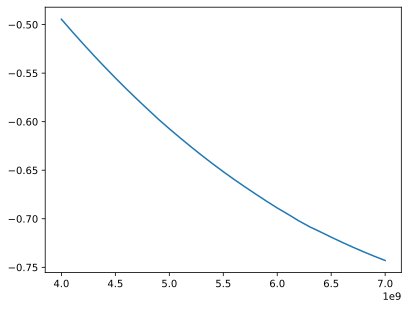

In [ ]:
plt.plot(results['freqs'], results['S21'], label='S21')

# Coupling two transmons

Here, we will discuss one of most basic form of coupling between two qubits. In this case, we have two xmons with a capacitive coupling mediated by a bus. A similar form of coupling can be established by bringing two qubit pads close to each other.

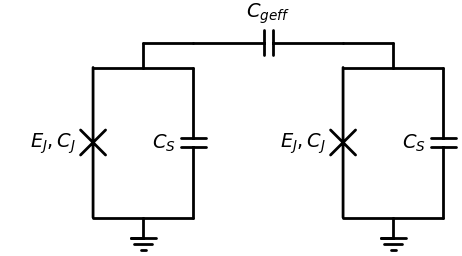

In [263]:
# Create a new drawing
d = schemdraw.Drawing()

# --- Define Nodes ---
bottom_node = (0,0) # Common ground node


# Drawing the qubit circuit
charge_node = d.here
d += elm.Line().down().length(0.5)
junction_node = d.here
d += elm.Line().left().length(1)
d += elm.Josephson().down().label('$E_J, C_J$')
d += elm.Line().right().length(1)
d += elm.Line().right().length(1).at(junction_node)
d += elm.Capacitor().down().label('$C_S$')
d += elm.Line().left().length(1)
d += elm.Ground()
d += elm.Line().right().length(1).at(charge_node)
d += elm.Capacitor().right().label('$C_{geff}$')
d += elm.Line().right().length(1)
# Drawing the resonator circuit
d += elm.Line().down().length(0.5)
resonator_node = d.here
d += elm.Line().left().length(1)
d += elm.Josephson().down().label('$E_J, C_J$')
d += elm.Line().right().length(1)
d += elm.Line().right().length(1).at(resonator_node)
d += elm.Capacitor().down().label('$C_S$')
d += elm.Line().left().length(1)
d += elm.Ground()
d.draw()

The total Hamiltonian of this system can be simplified as:
$$
H = H_1 + H_2 + H_{int}
$$,
which is sum of both qubit energies and the interaction energy between two sides of the circuit, $H_{int}$. The interaction energy is in the form of $H_{int} = C_g V_1 V_2$, where $C_g$ is coupling capacitance and $V_i$ is voltage operator. 

Using circuit quantization methods, we can get this interaction Hamiltonian as:
$$
H_{int} = 4e^2 \frac{C_g}{C_1 C_2}\hat{n}_1\hat{n}_2
$$

In this section, we will first find the effective coupling capacitance $C_g$ and calculate the coupling strength between two qubits.

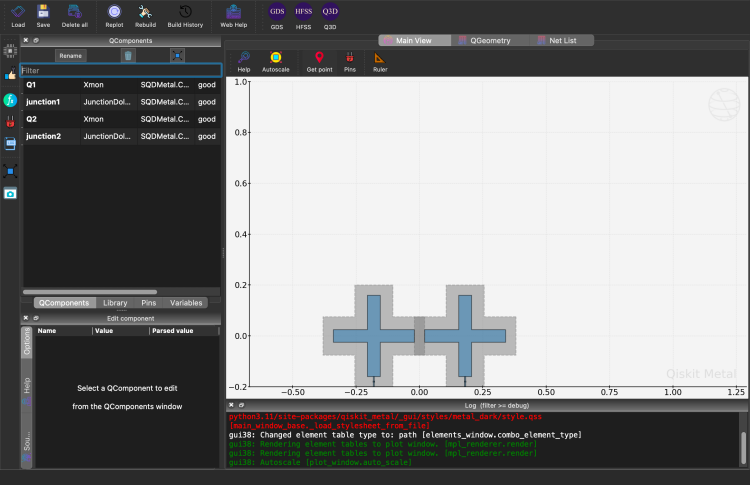

In [ ]:
design = designs.DesignPlanar({}, overwrite_enabled=True)
design.delete_all_components()
gui = MetalGUI(design)


# Set up chip dimensions 
design.chips.main.size.size_x = '2mm'
design.chips.main.size.size_y = '2mm'
design.chips.main.size.size_z = '-280um'
design.chips.main.size.center_x = '0mm'
design.chips.main.size.center_y = '0mm'

# Resonator and feedline gap width (W) and center conductor width (S) 
design.variables['cpw_width'] = '10 um' #S
design.variables['cpw_gap'] = '40 um' #W 
# Lets create the qubit with a junction and a claw

## Qubit
xmon1 = Xmon(design, 'Q1', options=Dict(pos_x = '-0.18mm', pos_y='0',
                                    vBar_width='50um', hBar_width='50um', vBar_gap=f'{50}um', hBar_gap=f'{50}um',
                                    cross_width=f'{320}um', cross_height=f'{320}um',
                                    gap_up='40um', gap_left='40um', gap_right='40um', gap_down='40um'))

# Junction
JunctionDolanPinStretch(design, 'junction1', options=Dict(pin_inputs=Dict(start_pin=Dict(component=f'Q1',pin='down')),
                                                         dist_extend='40um',
                                                         layer=2,
                                                         finger_width='0.4um', t_pad_size='0.385um',
                                                         squid_width='5.4um', prong_width='0.9um'))



xmon2 = Xmon(design, 'Q2', options=Dict(pos_x = '0.18mm', pos_y='0',
                                    vBar_width='50um', hBar_width='50um', vBar_gap=f'{50}um', hBar_gap=f'{50}um',
                                    cross_width=f'{320}um', cross_height=f'{320}um',
                                    gap_up='40um', gap_left='40um', gap_right='40um', gap_down='40um'))

# Junction
JunctionDolanPinStretch(design, 'junction2', options=Dict(pin_inputs=Dict(start_pin=Dict(component=f'Q2',pin='down')),
                                                         dist_extend='40um',
                                                         layer=2,
                                                         finger_width='0.4um', t_pad_size='0.385um',
                                                         squid_width='5.4um', prong_width='0.9um'))



gui.rebuild()
gui.autoscale()
gui.screenshot('sims/qubit-qubit.png')

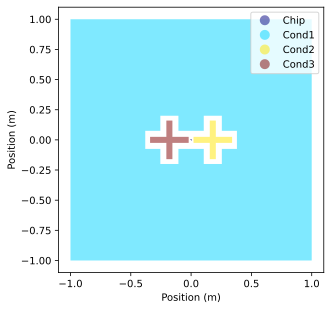

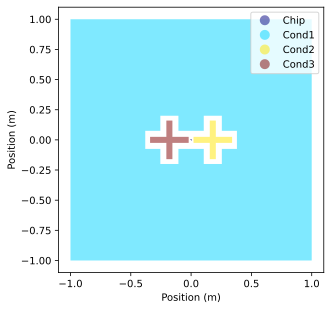

In [ ]:
from SQDMetal.PALACE.Capacitance_Simulation import PALACE_Capacitance_Simulation

user_defined_options = {
                "mesh_refinement": 0,                             #refines mesh in PALACE - essetially divides every mesh element in half
                "dielectric_material": "silicon",                  #choose dielectric material - 'silicon' or 'sapphire'
                "solver_order": 1,                                 #increasing solver order increases accuracy of simulation, but significantly increases sim time
                "solver_tol": 1.0e-8,                              #error residual tolerance for iterative solver
                "solver_maxits": 500,                              #number of solver iterations
                "mesh_max": 120e-6,                                #maxiumum element size for the mesh in mm
                "mesh_sampling": 150,                              #number of points to mesh along a geometry
                "fillet_resolution":12,                            #number of vertices per quarter turn on a filleted path
                "num_cpus": 10,                                      #number of CPU cores to use for simulation
                "palace_dir":path_to_palace
                }
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
os.environ["PMIX_MCA_gds"]="hash"

import gmsh
gmsh.initialize()


os.makedirs('sims', exist_ok=True)
#Creat the Palace Eigenmode simulation
cap_sim = PALACE_Capacitance_Simulation(name = 'transmon_cross_cap_sim',                                 #name of simulation
                                        metal_design = design,                                      #feed in qiskit metal design
                                        sim_parent_directory = "sims/",            #choose directory where mesh file, config file and HPC batch file will be saved
                                        mode = 'simPC',                                             #choose simulation mode 'HPC' or 'simPC'
                                        meshing = 'GMSH',                                           #choose meshing 'GMSH' or 'COMSOL'
                                        user_options = user_defined_options,                        #provide options chosen above
                                        view_design_gmsh_gui = False,                               #view design in GMSH gui
                                        create_files = True,
                                        )                                        #create mesh, config and HPC batch files

cap_sim.add_metallic(1, threshold=1e-10, fuse_threshold=1e-10)
cap_sim.add_ground_plane(threshold=1e-10)

for ii in ["Q1", "Q2"]:
    bounds = design.components[ii].qgeometry_bounds()
#Fine-mesh the transmon cross qubit region
    cap_sim.fine_mesh_in_rectangle(bounds[0]*1e-3, bounds[1]*1e-3, bounds[2]*1e-3, bounds[3]*1e-3, mesh_sampling=100, mesh_min=1e-6, mesh_max=50e-3)

cap_sim.prepare_simulation()
cap_sim.display_conductor_indices()





In [ ]:
from SQDMetal.PALACE.Utilities.GMSH_Navigator import GMSH_Navigator

# Let's look how the mesh looks in GMSH
# Open the GMSH GUI

gmsh_nav = GMSH_Navigator(cap_sim.path_mesh)
gmsh_nav.open_GUI()

In [ ]:
cap_matrix = cap_sim.run()

>> /opt/homebrew/bin/mpirun -n 10 /Users/mcansarihan/qubit_design/palace/build/bin/palace-arm64.bin transmon_cross_cap_sim.json

_____________     _______
_____   __   \____ __   /____ ____________
____   /_/  /  __ ` /  /  __ ` /  ___/  _ \
___   _____/  /_/  /  /  /_/  /  /__/  ___/
  /__/     \___,__/__/\___,__/\_____\_____/


--> Warning!
Output folder is not empty; program will overwrite content! (outputFiles)
Git changeset ID: v0.13.0-454-gcd4d7b78
Running with 10 MPI processes
Device configuration: cpu
Memory configuration: host-std
libCEED backend: /cpu/self/xsmm/blocked

Added 3495 duplicate vertices for interior boundaries in the mesh
Added 7606 duplicate boundary elements for interior boundaries in the mesh
Added 440 boundary elements for material interfaces to the mesh
Finished partitioning mesh into 10 subdomains

Characteristic length and time scales:
 L₀ = 2.400e-03 m, t₀ = 8.006e-03 ns

Mesh curvature order: 1
Mesh bounding box:
 (Xmin, Ymin, Zmin) = (-1.200e-03, -1.200

In [ ]:
cdf = pd.DataFrame(cap_matrix*1e15)

# get rid of the first column
cdf = cdf.iloc[:, 1:]

# assigning the columns and indices based on our geometry
cdf.columns = ["ground", "xmon2","xmon1"]
cdf.index = ["ground", "xmon2", "xmon1"]
cdf

,ground,xmon2,xmon1
ground,1786.620003,-69.593178,-69.597704
xmon2,-69.593178,96.644519,-4.108557
xmon1,-69.597704,-4.108557,96.596199


Based on the capacitance between two qubits, we can estimate our unitless coupling efficiency: $k_{q1q2} = C_g/\sqrt{C_1C_2}$

In [ ]:
coupling_eff = np.abs(cdf.loc["xmon2", "xmon1"]/np.sqrt(cdf.loc["xmon1","xmon1"]*cdf.loc["xmon2","xmon2"]))
print(f"Coupling Efficiency = {coupling_eff*100:.2f}%")

Coupling Efficiency = 4.25%


We will use our approximation to estimate the coupling strength between the two qubits.

$$
g = k_{q1q2} \sqrt{f_{q1} f_{q2}}/2
$$

In [ ]:
frequency_q1 = 4e9
frequency_q2 = 4e9

g = coupling_eff * frequency_q / 2 
print(f"Coupling Strength = {g*1000:.2f} MHz")

Coupling Strength = 104.27 MHz


## Two transmons coupled via bus

Here, we have added a bus waveguide to couple distant qubits to each other. We will see how the coupling changes with the distance between the qubits.

In [308]:

design = designs.DesignPlanar({}, overwrite_enabled=True)
design.delete_all_components()
gui = MetalGUI(design)


# Set up chip dimensions 
design.chips.main.size.size_x = '2mm'
design.chips.main.size.size_y = '2mm'
design.chips.main.size.size_z = '-280um'
design.chips.main.size.center_x = '0mm'
design.chips.main.size.center_y = '0mm'

# Resonator and feedline gap width (W) and center conductor width (S) 
design.variables['cpw_width'] = '10 um' #S
design.variables['cpw_gap'] = '40 um' #W 
# Lets create the qubit with a junction and a claw

## Qubit
xmon1 = Xmon(design, 'Q1', options=Dict(pos_x = '-0.4mm', pos_y='0',
                                    vBar_width='50um', hBar_width='50um', vBar_gap=f'{50}um', hBar_gap=f'{50}um',
                                    cross_width=f'{320}um', cross_height=f'{320}um',
                                    gap_up='40um', gap_left='40um', gap_right='40um', gap_down='40um'))

# Junction
JunctionDolanPinStretch(design, 'junction1', options=Dict(pin_inputs=Dict(start_pin=Dict(component=f'Q1',pin='down')),
                                                         dist_extend='40um',
                                                         layer=2,
                                                         finger_width='0.4um', t_pad_size='0.385um',
                                                         squid_width='5.4um', prong_width='0.9um'))


# # Claw
CapacitorProngPin(design, 'claw1', options=Dict(pin_inputs=Dict(start_pin=Dict(component=f'Q1',pin='right')),
                                                prong_width='10um', prong_length='20um', pin_gap_side='10um',
                                                gap_side='20um', pad_thickness='20um',
                                                gap_front='20um', gap_back='20um', trace_width='10um'))
xmon2 = Xmon(design, 'Q2', options=Dict(pos_x = '0.4mm', pos_y='0',
                                    vBar_width='50um', hBar_width='50um', vBar_gap=f'{50}um', hBar_gap=f'{50}um',
                                    cross_width=f'{320}um', cross_height=f'{320}um',
                                    gap_up='40um', gap_left='40um', gap_right='40um', gap_down='40um'))

# Junction
JunctionDolanPinStretch(design, 'junction2', options=Dict(pin_inputs=Dict(start_pin=Dict(component=f'Q2',pin='down')),
                                                         dist_extend='40um',
                                                         layer=2,
                                                         finger_width='0.4um', t_pad_size='0.385um',
                                                         squid_width='5.4um', prong_width='0.9um'))


# # Claw
CapacitorProngPin(design, 'claw2', options=Dict(pin_inputs=Dict(start_pin=Dict(component=f'Q2',pin='left')),
                                                prong_width='10um', prong_length='20um', pin_gap_side='10um',
                                                gap_side='20um', pad_thickness='20um',
                                                gap_front='20um', gap_back='20um', trace_width='10um'))


coupler = RouteStraight(design, 'coupler', Dict(hfss_wire_bonds = True,
        pin_inputs=Dict(
            start_pin=Dict(component='claw1', pin='a'),
            end_pin=Dict(component='claw2', pin='a')), ))


gui.rebuild()
gui.autoscale()

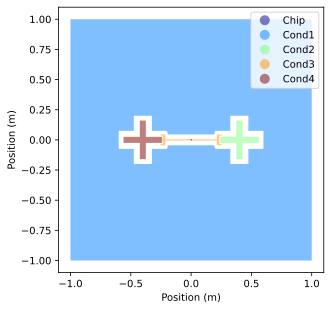

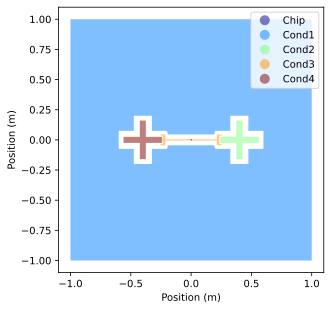

In [309]:
from SQDMetal.PALACE.Capacitance_Simulation import PALACE_Capacitance_Simulation

user_defined_options = {
                "mesh_refinement": 0,                             #refines mesh in PALACE - essetially divides every mesh element in half
                "dielectric_material": "silicon",                  #choose dielectric material - 'silicon' or 'sapphire'
                "solver_order": 1,                                 #increasing solver order increases accuracy of simulation, but significantly increases sim time
                "solver_tol": 1.0e-8,                              #error residual tolerance for iterative solver
                "solver_maxits": 500,                              #number of solver iterations
                "mesh_max": 120e-6,                                #maxiumum element size for the mesh in mm
                "mesh_sampling": 150,                              #number of points to mesh along a geometry
                "fillet_resolution":12,                            #number of vertices per quarter turn on a filleted path
                "num_cpus": 10,                                      #number of CPU cores to use for simulation
                "palace_dir":path_to_palace
                }
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
os.environ["PMIX_MCA_gds"]="hash"

import gmsh
gmsh.initialize()


os.makedirs('sims', exist_ok=True)
#Creat the Palace Eigenmode simulation
cap_sim = PALACE_Capacitance_Simulation(name = 'transmon_cross_cap_sim',                                 #name of simulation
                                        metal_design = design,                                      #feed in qiskit metal design
                                        sim_parent_directory = "sims/",            #choose directory where mesh file, config file and HPC batch file will be saved
                                        mode = 'simPC',                                             #choose simulation mode 'HPC' or 'simPC'
                                        meshing = 'GMSH',                                           #choose meshing 'GMSH' or 'COMSOL'
                                        user_options = user_defined_options,                        #provide options chosen above
                                        view_design_gmsh_gui = False,                               #view design in GMSH gui
                                        create_files = True,
                                        )                                        #create mesh, config and HPC batch files

cap_sim.add_metallic(1, threshold=1e-10, fuse_threshold=1e-10)
cap_sim.add_ground_plane(threshold=1e-10)

for ii in ["Q1", "Q2"]:
    bounds = design.components[ii].qgeometry_bounds()
#Fine-mesh the transmon cross qubit region
    cap_sim.fine_mesh_in_rectangle(bounds[0]*1e-3, bounds[1]*1e-3, bounds[2]*1e-3, bounds[3]*1e-3, mesh_sampling=100, mesh_min=1e-6, mesh_max=50e-3)

cap_sim.prepare_simulation()
cap_sim.display_conductor_indices()





In [310]:
cap_matrix = cap_sim.run()

>> /opt/homebrew/bin/mpirun -n 10 /Users/mcansarihan/qubit_design/palace/build/bin/palace-arm64.bin transmon_cross_cap_sim.json

_____________     _______
_____   __   \____ __   /____ ____________
____   /_/  /  __ ` /  /  __ ` /  ___/  _ \
___   _____/  /_/  /  /  /_/  /  /__/  ___/
  /__/     \___,__/__/\___,__/\_____\_____/


--> Warning!
Output folder is not empty; program will overwrite content! (outputFiles)
Git changeset ID: v0.13.0-454-gcd4d7b78
Running with 10 MPI processes
Device configuration: cpu
Memory configuration: host-std
libCEED backend: /cpu/self/xsmm/blocked

Added 118 elements in 2 iterations of local bisection for under-resolved interior boundaries
Added 4152 duplicate vertices for interior boundaries in the mesh
Added 9074 duplicate boundary elements for interior boundaries in the mesh
Added 440 boundary elements for material interfaces to the mesh
Finished partitioning mesh into 10 subdomains

Characteristic length and time scales:
 L₀ = 2.400e-03 m, t₀ = 8.006

In [311]:
cdf = pd.DataFrame(cap_matrix*1e15)

# get rid of the first column
cdf = cdf.iloc[:, 1:]

# assigning the columns and indices based on our geometry
cdf.columns = ["ground", "xmon2","bus","xmon1"]
cdf.index = ["ground", "xmon2","bus", "xmon1"]
cdf = cdf.reindex(index=["bus", "ground",  "xmon1","xmon2"], columns=["bus","ground",  "xmon1","xmon2"])
cdf

,bus,ground,xmon1,xmon2
bus,155.953757,-108.697917,-17.702593,-17.406808
ground,-108.697917,1880.397626,-67.103289,-67.294002
xmon1,-17.702593,-67.103289,106.806045,-0.004817
xmon2,-17.406808,-67.294002,-0.004817,106.692196


In [312]:
coupling_eff = (cdf.loc["bus", "xmon1"]/np.sqrt(cdf.loc["xmon1","xmon1"]*cdf.loc["bus","bus"])) * (cdf.loc["bus", "xmon2"]/np.sqrt(cdf.loc["xmon2","xmon2"]*cdf.loc["bus","bus"]))
print(f"Coupling Efficiency = {coupling_eff*100:.2f} %")

Coupling Efficiency = 1.85 %


We found our unitless coupling efficiency by multiplying the two coupling efficiencies between the bus and the two qubits. We will use our approximation to estimate the coupling strength between the two qubits.

$$
g = k_{q1q2} \sqrt{f_{q1} f_{q2}}/2
$$

In [ ]:
frequency_q1 = 4e9
frequency_q2 = 4e9

g = coupling_eff * np.sqrt(frequency_q1 * frequency_q2) / 2 
print(f"Coupling Strength = {g*1000:.2f} MHz")

Coupling Strength = 45.39 MHz


Using the second quantization, we can represent the interaction Hamiltonian as:

$H_{int} = g (a_1-a_1^†) (a_2-a_2^†)$
where a_1 and a_2 are the annihilation operators for the two qubits. 
If we truncate the higher energy levels and restrict our qubits to Pauli basis (only 0-1 levels), we can reduce this Hamiltonian to:
$$
H = \frac{1}{2} \omega_{q1}\sigma_{z1} + \frac{1}{2}  \omega_{q2}\sigma_{z2} + g\sigma_{y1}\sigma_{y2}
$$
We see that the resulting coupling term is on y-axis, which is arbitrary and can also be identified by x axis. This indicates the presence of an exchange interaction between the qubits and called as transverse coupling. Transverse coupling can be used to perform two-qubit entangling gates such as SWAP family of gates.

Of course, this holds only when the system is truncated to the first two energy levels and ignores the presence of higher order states and couplings. In reality, two qubits have a mix of both transverse and longitudinal couplings(in z-basis) during the operation.

Another caveat is, these kind of static capacitive interactions are always on, which poses a problem to coherence of the qubits when they are idle. In order to overcome these challenges, state-of-the-art implementations utilize tunable coupling schemes, where a second coupling channel with tunable coupling strength is used to negate the static capacitive coupling between two qubits.

# Extra References

You can refer to following articles to learn more about superconducting quantum devices and the design concerns. 

1. Megrant, A. & Chen, Y. Scaling up superconducting quantum computers. Nat. Electron. 1–3 (2025) doi:10.1038/s41928-025-01381-7.


2. Levenson-Falk, E. M. & Shanto, S. A. A Review of Design Concerns in Superconducting Quantum Circuits. arXiv (2024).


3. Vool, U. & Devoret, M. Introduction to quantum electromagnetic circuits. Int. J. Circuit Theory Appl. 45, 897–934 (2017).


4. Bardin, J. C., Slichter, D. H. & Reilly, D. J. Microwaves in Quantum Computing. IEEE J. Microwaves 1, 403–427 (2020).


5. Sete, E. A., Martinis, J. M. & Korotkov, A. N. Quantum theory of a bandpass Purcell filter for qubit readout. Phys. Rev. A 92, 012325 (2015).


6. Rasmussen, S. E. et al. Superconducting Circuit Companion—an Introduction with Worked Examples. PRX Quantum 2, 040204 (2021).


7. Gao, Y. Y., Rol, M. A., Touzard, S. & Wang, C. Practical Guide for Building Superconducting Quantum Devices. PRX Quantum 2, 040202 (2021).


8. Blais, A., Grimsmo, A. L., Girvin, S. M. & Wallraff, A. Circuit quantum electrodynamics. Rev. Mod. Phys. 93, 025005 (2021).


9. Blais, A., Girvin, S. M. & Oliver, W. D. Quantum information processing and quantum optics with circuit quantum electrodynamics. Nat. Phys. 16, 247–256 (2020).


10. Krantz, P. et al. A quantum engineer’s guide to superconducting qubits. Appl. Phys. Rev. 6, 021318 (2019).


11. Kjaergaard, M. et al. Superconducting Qubits: Current State of Play. Annu. Rev. Conden. Ma. P. 11, 1–27 (2019).


12. Siddiqi, I. Engineering high-coherence superconducting qubits. Nat. Rev. Mater. 6, 875–891 (2021).


13. Wendin, G. Quantum information processing with superconducting circuits: a review. Rep. Prog. Phys. 80, 106001 (2017).

14. Koch, J. et al. Charge-insensitive qubit design derived from the Cooper pair box. Phys. Rev. A 76, 042319 (2007).


15. Houck, A. A. et al. Controlling the Spontaneous Emission of a Superconducting Transmon Qubit. Phys. Rev. Lett. 101, 080502 (2008).


16. Barends, R. et al. Superconducting quantum circuits at the surface code threshold for fault tolerance. Nature 508, 500–503 (2014).

17. Barends, R. et al. Coherent Josephson Qubit Suitable for Scalable Quantum Integrated Circuits. Phys. Rev. Lett. 111, 080502 (2013).
  



## Supplementary : Simulating resonator and feedline only

Logger issue: Internal C++ object (QTextEditLogger) already deleted.
Logger issue: Internal C++ object (QTextEditLogger) already deleted.


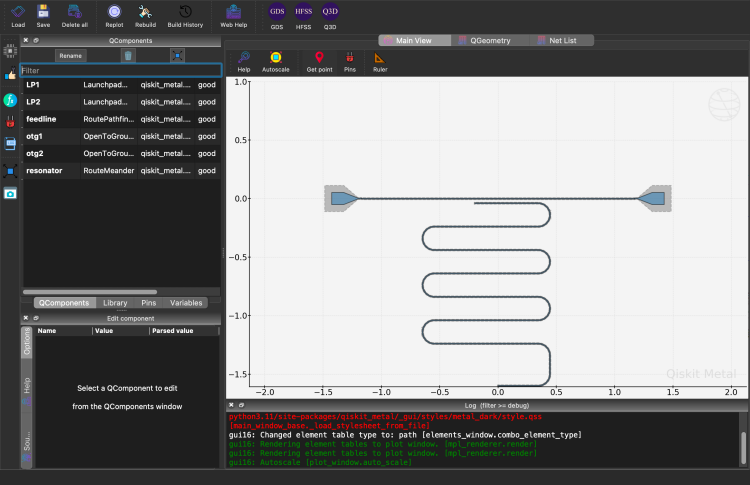

In [109]:
design = designs.DesignPlanar({}, overwrite_enabled=True)
design.delete_all_components()
gui = MetalGUI(design)


# Set up chip dimensions 
design.chips.main.size.size_x = '3.5mm'
design.chips.main.size.size_y = '3mm'
design.chips.main.size.size_z = '-280um'
design.chips.main.size.center_x = '0mm'
design.chips.main.size.center_y = '-1mm'

# Resonator and feedline gap width (W) and center conductor width (S) 
design.variables['cpw_width'] = '8 um' #S
design.variables['cpw_gap'] = '4 um' #W 
# Lets create the qubit with a junction and a claw


# Lauchpad 1
x1 = '-1.2mm'
y1 = '0mm'
launch_options1 = dict(chip='main', pos_x=x1, pos_y=y1, orientation='360', lead_length='30um', pad_height='103um', 
                      pad_width='103um', pad_gap='60um')
LP1 = LaunchpadWirebond(design, 'LP1', options = launch_options1)

# Launchpad 2
x2 = '1.2mm'
y1 = '0mm'
launch_options2 = dict(chip='main', pos_x=x2, pos_y=y1, orientation='180', lead_length='30um', pad_height='103um', 
                      pad_width='103um', pad_gap='60um')
LP2 = LaunchpadWirebond(design, 'LP2', options = launch_options2)

# Using path finder to connect the two launchpads
feedline = RoutePathfinder(design, 'feedline', options = dict(chip='main', trace_width ='8um',
                                            trace_gap ='4um',
                                            fillet='200um',                                                            
                                            hfss_wire_bonds = True,
                                            lead=dict(end_straight='0.1mm'),
                                            pin_inputs=Dict(
                                                start_pin=Dict(
                                                    component='LP1',
                                                    pin='tie'),
                                                end_pin=Dict(
                                                    component='LP2',
                                                    pin='tie')
                                            )))
#open to ground for resonator
otg1 = OpenToGround(design, 'otg1', options=dict(chip='main', pos_x='-0.2mm',  pos_y='-40um', orientation = 180, width = '8um', gap='4um',))
otg2 = OpenToGround(design, 'otg2', options=dict(chip='main', pos_x='-0mm',  pos_y='-1.6mm', orientation = 180, width = '8um', gap='4um',))
# Use RouteMeander to fix the total length of the resonator
res1 = RouteMeander(design, 'resonator',  Dict(
        trace_width ='8um',
        trace_gap ='4um',
        total_length='8.6mm',
        hfss_wire_bonds = False,
        fillet='100um',
        lead = dict(start_straight='100um'),
        meander = dict(spacing='0.2mm'),
        pin_inputs=Dict(
        start_pin=Dict(component= 'otg1', pin= 'open'),
        end_pin=Dict(component= 'otg2', pin= 'open')), ))

# rebuild the GUI
design.rebuild()
gui.rebuild()
gui.autoscale()
gui.screenshot('sims/qubit-cavity.png')


In [110]:

## Eigenmodal Simulation


#Define the hyper-parameters for the eigenmode simulation
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
os.environ["PMIX_MCA_gds"]="hash"

import gmsh
gmsh.initialize()
# Define the hyper-parameters for the eigenmode simulation
from SQDMetal.PALACE.Eigenmode_Simulation import PALACE_Eigenmode_Simulation

#Eigenmode Simulation Options
user_defined_options = {
                 "mesh_refinement":  0,                             #refines mesh in PALACE - essetially divides every mesh element in half
                 "dielectric_material": "silicon",                  #choose dielectric material - 'silicon' or 'sapphire'
                 "starting_freq": 3e9,                              #starting frequency in Hz 
                 "number_of_freqs":6,                              #number of eigenmodes to find
                 "solns_to_save": 6,                                #number of electromagnetic field visualizations to save
                 "solver_order": 1,                                 #increasing solver order increases accuracy of simulation, but significantly increases sim time
                 "solver_tol": 5.0e-4,                              #error residual tolerance foriterative solver
                 "solver_maxits": 10,                              #number of solver iterations
                 "mesh_max": 120e-3,                                #maxiumum element size for the mesh in mm
                 "mesh_min": 10e-3,                                 #minimum element size for the mesh in mm
                 "mesh_sampling": 130,                              #number of points to mesh along a geometry
                 "fillet_resolution":12,   
                 "num_cpus": 4,                                      #number of CPU cores to use for simulation
                 "palace_dir":path_to_palace
                }

#Creat the Palace Eigenmode simulation
eigen_sim = PALACE_Eigenmode_Simulation(name ='GMSH_eigen_test',                              #name of simulation
                                        metal_design = design,                                      #feed in qiskit metal design
                                        sim_parent_directory = "sims/",            #choose directory where mesh file, config file and HPC batch file will be saved
                                        mode = 'simPC',                                               #choose simulation mode 'HPC' or 'simPC'                                          
                                        meshing = 'GMSH',                                         #choose meshing 'GMSH' or 'COMSOL'
                                        user_options = user_defined_options,                        #provide options chosen above
                                        view_design_gmsh_gui = False,                               #view design in GMSH gui 
                                        create_files = True)                                        #create mesh, config and HPC batch files

# Assigning the materials to the interfaces, add ports to the design, and add some mesh.


eigen_sim.add_metallic(1, threshold=1e-10, fuse_threshold=1e-10)
eigen_sim.add_ground_plane(threshold=1e-10)

#Fine-mesh the transmon cross qubit region
# bounds = design.components["xmon"].qgeometry_bounds()
# eigen_sim.fine_mesh_in_rectangle(bounds[0]*1e-3, bounds[1]*1e-3, bounds[2]*1e-3, bounds[3]*1e-3, mesh_sampling=100, mesh_min=15e-6, mesh_max=120e-6)

#Add in the RF ports
eigen_sim.create_port_CPW_on_Launcher('LP1', 20e-6,)
eigen_sim.create_port_CPW_on_Launcher('LP2', 20e-6,)
# eigen_sim.create_port_JosephsonJunction('junction', L_J=L_junction, C_J=2e-15)

# #Fine-mesh routed paths

eigen_sim.fine_mesh_around_comp_boundaries(['feedline', 'resonator'], min_size=25e-6, max_size=250e-6)
# eigen_sim.fine_mesh_around_comp_boundaries(['xmon','junction'], min_size=14e-6, max_size=75e-6)

eigen_sim.setup_EPR_interfaces(metal_air=MaterialInterface('Aluminium-Vacuum'), substrate_air=MaterialInterface('Silicon-Vacuum'), substrate_metal=MaterialInterface('Silicon-Aluminium'))
eigen_sim.prepare_simulation()


# from SQDMetal.PALACE.Utilities.GMSH_Navigator import GMSH_Navigator

# # Let's look how the mesh looks in GMSH
# # Open the GMSH GUI

# gmsh_nav = GMSH_Navigator(eigen_sim.path_mesh)
# gmsh_nav.open_GUI()


In [111]:
import json

#This is required for Palace to run eigenmode simulation while 50 ohm ports are used
with open(eigen_sim._sim_config, 'r') as file:
    sim_config_dict = json.load(file)
print(sim_config_dict)

del sim_config_dict["Boundaries"]["LumpedPort"][0]["Excitation"]

with open(eigen_sim._sim_config, 'w') as file:
    json.dump(sim_config_dict, file, indent=4)
# If all looks good, lets run the simulation
eigen_sim.run()
# Reading the eigenmode data now
def read_csv_to_dataframe(file_path):
    return pd.read_csv(file_path)

eigen_df = read_csv_to_dataframe(os.path.join(eigen_sim._output_data_dir, 'eig.csv'))
eigen_df.columns = eigen_df.columns.str.strip()
eigen_df["kappa (kHz)"] = eigen_df["Re{f} (GHz)"] / eigen_df["Q"] * 1e6
eigen_df
# Reading the eigenmode data now
def read_csv_to_dataframe(file_path):
    return pd.read_csv(file_path)

eigen_df = read_csv_to_dataframe(os.path.join(eigen_sim._output_data_dir, 'eig.csv'))
eigen_df.columns = eigen_df.columns.str.strip()
eigen_df["kappa (kHz)"] = eigen_df["Re{f} (GHz)"] / eigen_df["Q"] * 1e6
eigen_df

{'Problem': {'Type': 'Eigenmode', 'Verbose': 2, 'Output': 'outputFiles'}, 'Model': {'Mesh': 'GMSH_eigen_test.msh', 'L0': 0.001, 'Refinement': {'UniformLevels': 0}}, 'Domains': {'Materials': [{'Attributes': [10], 'Permeability': 1.0, 'Permittivity': 1.0, 'LossTan': 0.0}, {'Attributes': [9], 'Permeability': 1, 'Permittivity': 11.45, 'LossTan': 2.7e-06}]}, 'Boundaries': {'PEC': {'Attributes': [1, 2, 3]}, 'LumpedPort': [{'Index': 1, 'Elements': [{'Attributes': [4], 'Direction': [-0.0, -1.0, 0]}, {'Attributes': [5], 'Direction': [0.0, 1.0, 0]}], 'R': 50, 'L': 0, 'C': 0, 'Excitation': True}, {'Index': 2, 'Elements': [{'Attributes': [6], 'Direction': [0.0, 1.0, 0]}, {'Attributes': [7], 'Direction': [-0.0, -1.0, 0]}], 'R': 50, 'L': 0, 'C': 0}], 'Postprocessing': {'Dielectric': [{'Index': 1, 'Attributes': [8], 'Type': 'SA', 'Thickness': 2e-06, 'Permittivity': 3.85, 'LossTan': 0.006}, {'Index': 2, 'Attributes': [1, 2, 3], 'Type': 'MS', 'Thickness': 2e-06, 'Permittivity': 10.0, 'LossTan': 0.0003}

,m,Re{f} (GHz),Im{f} (GHz),Q,Error (Bkwd.),Error (Abs.),kappa (kHz)
0,1.0,4.423454,-4.597743,0.693834,1.380610e-07,0.109316,6.375379e+06
1,2.0,4.878758,0.052177,46.754899,1.460089e-07,0.115609,1.043475e+05
2,3.0,4.970088,-7.227603,0.606809,5.447809e-07,0.431358,8.190535e+06
3,4.0,6.173305,0.005248,588.146738,9.751172e-08,0.077210,1.049620e+04
4,5.0,6.918562,0.072031,48.027786,1.070044e-07,0.084726,1.440533e+05
5,6.0,8.346343,0.143428,29.100304,1.422629e-07,0.112644,2.868129e+05
